Hi! The purpose of this project is to detect when Pépito (https://twitter.com/PepitoTheCat) is leaving or when Pépito is back at home.

I've downloaded all the images posted from his Twitter account (up to this date: 2018/06/06). There are 10,041 images plus another 227 images that I'm not gonna use since they have a different resolution (I want to keep this simple, at least for now that I'm starting). I'm not uploading the images to the GitHub repo, but if you want them ask me and I'll find a way to publish them!

The positive class will be 'out', and I'll do my best to avoid predicting Pépito is at home when he's actually out (If I were the owner of the almighty Pépito I would be very worried if my prediction system tells me Pépito is with me, safe at home when he's actually outside in the cold and hungry :( )



## Data exploration

In [0]:
#from numpy.random import seed
#seed(0)
#from tensorflow import set_random_seed
#set_random_seed(0)

In [0]:
# Specially check for how unbalanced classes are
# execute
import pandas as pd

In [3]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse

# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass

# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# # !gcloud config set project pepito
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# !mkdir -p drive
# !google-drive-ocamlfuse drive

In [5]:
from google.colab import files
uploaded = files.upload()

Saving labeled_images.csv to labeled_images.csv


In [0]:
# execute
!tar -xzf ./train_transformed_images.tar.gz
!tar -xzf ./dev_transformed_images.tar.gz
!tar -xzf ./models.tar.gz
!tar -xzf ./test.tar.gz

In [0]:
# execute
labelled_images = pd.read_csv('./labeled_images.csv')

In [5]:
label_count = labelled_images.groupby('label').count()[['img_name']]
label_count

,img_name
label,
home,5762
out,4279


In [22]:
print('prct home labels: %.3f' % ( (5762 / (5762+4297)) * 100) )

prct home labels: 57.282


In [7]:
print('prct home labels: %.3f' % ( (4279 / (5762+4297)) * 100) )

prct home labels: 42.539


Classes are not too unbalanced. But I think this shows possible bot problems, because it means there are consecutive classes and that shouldn't be possible because if Pépito leaves there's no way he can leave home again, he must have gotten back home before. Anyway, I'm sure there are other reason I don't know.

## Data splitting

In [0]:
# execute
from sklearn.utils import shuffle
SEED = 0
labelled_images = shuffle(labelled_images, random_state = SEED)

# older SEED values: 19121993

In [9]:
# execute
from sklearn.model_selection import train_test_split

data_x = labelled_images[['img_name']]
data_y = labelled_images[['label']]

train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, train_size=0.8, random_state=SEED, stratify = data_y.get_values())
dev_x, test_x, dev_y, test_y = train_test_split(test_x, test_y, train_size=0.5, random_state=SEED, stratify = test_y)
train_x, train_dev_x, train_y, train_dev_y = train_test_split(train_x, train_y, train_size=0.9, random_state=SEED, stratify = train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Number and percentage of each class on dev split. I don't think it's too unbalanced.

In [9]:
print(len(dev_y[dev_y['label'] == 'out']))
print('prct out labels: %.3f' % ( (428 / (428+576)) * 100) )
print(len(dev_y[dev_y['label'] == 'home']))
print('prct home labels: %.3f' % ( (576 / (428+576)) * 100) )

428
prct out labels: 42.629
576
prct home labels: 57.371


After thinking about this, I'm gonna mix day and night pics and see how the model works. In case it doesn't work (among many other things) it would be worth it to pay more attention to this and make the train and dev splits to be as similar as possible.

I assume (I haven't checked every picture, sorry) the camera is fixed and its angle doesn't change.

Simple undersampling to have a balanced training set:

In [10]:
# execute
import numpy as np

classes, counts = np.unique(train_y, return_counts = True)

print('%s %i' % (classes[0], counts[0]))
print('%s %i' % (classes[1], counts[1]))

home_indices_undersampl = np.random.choice(train_y.index[train_y['label'] == 'home'].tolist(), np.min(counts), replace=False)

all_indices = np.concatenate([np.array(train_y.index[train_y['label'] == 'out'].tolist()), home_indices_undersampl])
all_indices = np.array([x for x in np.array(train_y.index) if x in all_indices])

train_y = train_y.loc[all_indices]
train_x = train_x.loc[all_indices]

classes, counts = np.unique(train_y, return_counts = True)

print('%s %i' % (classes[0], counts[0]))
print('%s %i' % (classes[1], counts[1]))

home 4148
out 3080
home 3080
out 3080


Balancing dev set:

In [11]:
# execute
import numpy as np

classes, counts = np.unique(dev_y, return_counts = True)

print('%s %i' % (classes[0], counts[0]))
print('%s %i' % (classes[1], counts[1]))

home_indices_undersampl = np.random.choice(dev_y.index[dev_y['label'] == 'home'].tolist(), np.min(counts), replace=False)

all_indices = np.concatenate([np.array(dev_y.index[dev_y['label'] == 'out'].tolist()), home_indices_undersampl])
all_indices = np.array([x for x in np.array(dev_y.index) if x in all_indices])

dev_y = dev_y.loc[all_indices]
dev_x = dev_x.loc[all_indices]

classes, counts = np.unique(dev_y, return_counts = True)

print('%s %i' % (classes[0], counts[0]))
print('%s %i' % (classes[1], counts[1]))

home 576
out 428
home 428
out 428


# Creating folders structure

In [0]:
# Create images train/train-dev/dev/test splits

import os, errno
from shutil import copyfile
import logging

def create_folder(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise        

def create_folder_structures(folder_name, data_x, data_y):
    data = pd.concat([data_x, data_y], axis=1)
    
    folder_name_full_path = os.path.join('./', folder_name)
    
    create_folder(folder_name_full_path)
    
    home_imgs_full_path = os.path.join(folder_name_full_path, 'home')
    out_imgs_full_path = os.path.join(folder_name_full_path, 'out')
    
    create_folder(home_imgs_full_path)
    create_folder(out_imgs_full_path)
    
    logger = logging.getLogger('info_logger')
    logger.setLevel(logging.INFO)
    
    for row in data.itertuples(index=True):      
        file_full_path = os.path.join('./', getattr(row, 'img_name'))
        
        if os.path.isfile(file_full_path): 
            if getattr(row, 'label') == 'home':            
                copyfile(file_full_path, os.path.join(home_imgs_full_path, getattr(row, 'img_name')))
            elif getattr(row, 'label') == 'out':
                copyfile(file_full_path, os.path.join(out_imgs_full_path, getattr(row, 'img_name')))          
        else:
            logger.info('%s is an old pic and it won\'t be used' % getattr(row, 'img_name'))

In [0]:
train_folder_name = 'train'
train_dev_folder_name = 'train_dev'
dev_folder_name = 'dev'
test_folder_name = 'test'

In [0]:
create_folder_structures(train_folder_name, train_x, train_y)
create_folder_structures(train_dev_folder_name, train_dev_x, train_dev_y)
create_folder_structures(dev_folder_name, dev_x, dev_y)
create_folder_structures(test_folder_name, test_x, test_y)

# Applying transformations to images

Once the pics folder structure was created, I proceeded to apply transformations to images. I do this because at the beginning of this project I trained a model and the metric on the train set reached the value 1. The metric for the dev set wasn't too far from the train's, but I didn't look right to me because it might be suffering overfitting. 

The transformations applied were rotation (range = 10) and zoom (range = 0.1)



In [12]:
# execute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os

datagen = ImageDataGenerator(rescale=1./255, data_format = 'channels_first', 
                             rotation_range = 10, zoom_range = 0.1,
                             fill_mode = 'nearest')

BATCH_SIZE = 128

Using TensorFlow backend.


In [0]:
!mkdir ./train/home/out
!rsync -Rr ./train/home ./train/home/home/

In [56]:
i = 1

for batch in datagen.flow_from_directory('./train/home', 
                                         target_size=(480, 640), batch_size=BATCH_SIZE, 
#                                          class_mode='binary', classes = ['out', 'home'], 
                                         shuffle = True, seed=SEED, save_to_dir='train_transformed_imgs_home',
                                         save_format='jpg'):
  
  if i == np.floor(3078 / BATCH_SIZE):
    break
  
  i = i + 1

Found 3077 images belonging to 2 classes.


In [59]:
!tar -zcvf train_transformed_imgs_home.tar.gz train_transformed_imgs_home

train_transformed_imgs_home/
train_transformed_imgs_home/_158_5010839.jpg
train_transformed_imgs_home/_545_5980514.jpg
train_transformed_imgs_home/_870_3610921.jpg
train_transformed_imgs_home/_2740_6642580.jpg
train_transformed_imgs_home/_2013_9436984.jpg
train_transformed_imgs_home/_369_2290408.jpg
train_transformed_imgs_home/_97_9312737.jpg
train_transformed_imgs_home/_485_7339005.jpg
train_transformed_imgs_home/_1383_182793.jpg
train_transformed_imgs_home/_2476_7427748.jpg
train_transformed_imgs_home/_2021_4610898.jpg
train_transformed_imgs_home/_2925_6807213.jpg
train_transformed_imgs_home/_2901_4974894.jpg
train_transformed_imgs_home/_1057_3074230.jpg
train_transformed_imgs_home/_250_4198420.jpg
train_transformed_imgs_home/_3067_3077071.jpg
train_transformed_imgs_home/_1967_8301354.jpg
train_transformed_imgs_home/_1072_7058637.jpg
train_transformed_imgs_home/_356_7130479.jpg
train_transformed_imgs_home/_465_7285631.jpg
train_transformed_imgs_home/_1104_2478496.jpg
train_transforme

In [0]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()

In [0]:
# Saving transformed train images to Google Drive
drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
    file_metadata = {
      'name': name,
      'mimeType': 'application/octet-stream'
     }
    
    media = MediaFileUpload(path, 
                    mimetype='application/octet-stream',
                    resumable=True)

    created = drive_service.files().create(body=file_metadata,
                                   media_body=media,
                                   fields='id').execute()

    print('File ID: {}'.format(created.get('id')))

    return created

In [60]:
save_file_to_drive('train_transformed_imgs_home.tar.gz', './train_transformed_imgs_home.tar.gz')

File ID: 1qpbHU-GAonZ-Yvk_82-74wFQQmIoL1ph


{'id': '1qpbHU-GAonZ-Yvk_82-74wFQQmIoL1ph'}

In [0]:
!mkdir ./train/out/home
!rsync -Rr ./train/out ./train/out/out

In [45]:
!find ./train/out/out -type f | wc -l

3080


In [46]:
i = 1

for batch in datagen.flow_from_directory('train/out', 
                                         target_size=(480, 640), batch_size=BATCH_SIZE, 
                                         class_mode='binary', classes = ['out', 'home'], 
                                         shuffle = True, seed=SEED, save_to_dir='train_transformed_imgs_out',
                                         save_format='jpg'):
  
  if i == np.ceil(3080 / BATCH_SIZE):
    break
  
  i = i + 1

Found 3080 images belonging to 2 classes.


In [47]:
!tar -zcvf train_transformed_imgs_out.tar.gz train_transformed_imgs_out

train_transformed_imgs_out/
train_transformed_imgs_out/_2484_8773137.jpg
train_transformed_imgs_out/_1003_3345470.jpg
train_transformed_imgs_out/_102_7962437.jpg
train_transformed_imgs_out/_1612_6826539.jpg
train_transformed_imgs_out/_295_2510836.jpg
train_transformed_imgs_out/_472_8152640.jpg
train_transformed_imgs_out/_2273_5098764.jpg
train_transformed_imgs_out/_2653_5863231.jpg
train_transformed_imgs_out/_64_180726.jpg
train_transformed_imgs_out/_1874_7130479.jpg
train_transformed_imgs_out/_3077_3867426.jpg
train_transformed_imgs_out/_1648_9944119.jpg
train_transformed_imgs_out/_1521_3017512.jpg
train_transformed_imgs_out/_1831_257322.jpg
train_transformed_imgs_out/_807_2247136.jpg
train_transformed_imgs_out/_2016_4545278.jpg
train_transformed_imgs_out/_1087_3193718.jpg
train_transformed_imgs_out/_2516_4744828.jpg
train_transformed_imgs_out/_1467_8283009.jpg
train_transformed_imgs_out/_84_3080406.jpg
train_transformed_imgs_out/_2787_3220469.jpg
train_transformed_imgs_out/_1264_4006

In [48]:
# Saving transformed train images to Google Drive
save_file_to_drive('train_transformed_imgs_out.tar.gz', './train_transformed_imgs_out.tar.gz')

File ID: 12hq3l_5PARdsXGhJ0RrzE4Lul-SSuO45


{'id': '12hq3l_5PARdsXGhJ0RrzE4Lul-SSuO45'}

In [63]:
!mkdir ./dev/home/out
!rsync -Rr ./dev/home ./dev/home/home

mkdir: cannot create directory ‘./dev/home/out’: File exists


In [64]:
!find ./dev/home/home -type f | wc -l

427


In [0]:
!mkdir ./dev_transformed_imgs_home

In [67]:
i = 1

for batch in datagen.flow_from_directory('dev/home', 
                                         target_size=(480, 640), batch_size=BATCH_SIZE, 
                                         class_mode='binary', classes = ['out', 'home'], 
                                         shuffle = True, seed=SEED, save_to_dir='dev_transformed_imgs_home',
                                         save_format='jpg'):
  
  if i == np.ceil(427 / BATCH_SIZE):
    break
  
  i = i + 1

Found 427 images belonging to 2 classes.


In [68]:
!find ./dev_transformed_imgs_home -type f | wc -l

427


In [69]:
!tar -zcvf dev_transformed_imgs_home.tar.gz dev_transformed_imgs_home

dev_transformed_imgs_home/
dev_transformed_imgs_home/_275_2973394.jpg
dev_transformed_imgs_home/_343_4605348.jpg
dev_transformed_imgs_home/_294_9629033.jpg
dev_transformed_imgs_home/_354_5850342.jpg
dev_transformed_imgs_home/_359_2453305.jpg
dev_transformed_imgs_home/_73_5695421.jpg
dev_transformed_imgs_home/_362_8283009.jpg
dev_transformed_imgs_home/_418_209448.jpg
dev_transformed_imgs_home/_2_7189460.jpg
dev_transformed_imgs_home/_21_7930617.jpg
dev_transformed_imgs_home/_67_8739885.jpg
dev_transformed_imgs_home/_292_6932126.jpg
dev_transformed_imgs_home/_108_8181025.jpg
dev_transformed_imgs_home/_22_4267982.jpg
dev_transformed_imgs_home/_377_4055175.jpg
dev_transformed_imgs_home/_52_3737283.jpg
dev_transformed_imgs_home/_410_9403292.jpg
dev_transformed_imgs_home/_413_7660765.jpg
dev_transformed_imgs_home/_34_1371075.jpg
dev_transformed_imgs_home/_121_4566660.jpg
dev_transformed_imgs_home/_334_1439019.jpg
dev_transformed_imgs_home/_161_8410498.jpg
dev_transformed_imgs_home/_6_8031087

In [70]:
# Saving transformed train images to Google Drive
save_file_to_drive('dev_transformed_imgs_home.tar.gz', './dev_transformed_imgs_home.tar.gz')

File ID: 1yS-8iRhNYeWyRVO2bbyRU4zHqEfE4AKX


{'id': '1yS-8iRhNYeWyRVO2bbyRU4zHqEfE4AKX'}

In [0]:
!mkdir ./dev/out/home
!rsync -Rr ./dev/out ./dev/out/out

In [73]:
!find ./dev/out/out -type f | wc -l

428


In [0]:
!mkdir ./dev_transformed_imgs_out

In [0]:
i = 1

for batch in datagen.flow_from_directory('dev/out', 
                                         target_size=(480, 640), batch_size=BATCH_SIZE, 
                                         class_mode='binary', classes = ['out', 'home'], 
                                         shuffle = True, seed=SEED, save_to_dir='dev_transformed_imgs_out',
                                         save_format='jpg'):
  
  if i == np.ceil(428 / BATCH_SIZE):
    break
  
  i = i + 1

Found 428 images belonging to 2 classes.


In [76]:
!find ./dev_transformed_imgs_out -type f | wc -l

428


In [77]:
!tar -zcvf dev_transformed_imgs_out.tar.gz dev_transformed_imgs_out

dev_transformed_imgs_out/
dev_transformed_imgs_out/_275_2973394.jpg
dev_transformed_imgs_out/_178_22583.jpg
dev_transformed_imgs_out/_73_5695421.jpg
dev_transformed_imgs_out/_2_7189460.jpg
dev_transformed_imgs_out/_21_7930617.jpg
dev_transformed_imgs_out/_25_282197.jpg
dev_transformed_imgs_out/_67_8739885.jpg
dev_transformed_imgs_out/_108_8181025.jpg
dev_transformed_imgs_out/_22_4267982.jpg
dev_transformed_imgs_out/_52_3737283.jpg
dev_transformed_imgs_out/_192_9831458.jpg
dev_transformed_imgs_out/_62_1944292.jpg
dev_transformed_imgs_out/_303_4823718.jpg
dev_transformed_imgs_out/_414_4859042.jpg
dev_transformed_imgs_out/_34_1371075.jpg
dev_transformed_imgs_out/_310_397255.jpg
dev_transformed_imgs_out/_131_492938.jpg
dev_transformed_imgs_out/_161_8410498.jpg
dev_transformed_imgs_out/_6_8031087.jpg
dev_transformed_imgs_out/_40_710210.jpg
dev_transformed_imgs_out/_201_9334644.jpg
dev_transformed_imgs_out/_247_7793825.jpg
dev_transformed_imgs_out/_227_3387075.jpg
dev_transformed_imgs_out/_7

In [78]:
# Saving transformed dev images to Google Drive
save_file_to_drive('dev_transformed_imgs_out.tar.gz', './dev_transformed_imgs_out.tar.gz')

File ID: 1HQRqafHv8E4x2PB94Vmsld7EPNnhpg2e


{'id': '1HQRqafHv8E4x2PB94Vmsld7EPNnhpg2e'}

In [0]:
!mkdir ./train_transformed_images
!mkdir ./train_transformed_images/home
!mkdir ./train_transformed_images/out

In [0]:
!cp ./train_transformed_imgs_home/* ./train_transformed_images/home

In [0]:
!cp ./train_transformed_imgs_out/* ./train_transformed_images/out

In [0]:
!mkdir ./dev_transformed_images
!mkdir ./dev_transformed_images/home
!mkdir ./dev_transformed_images/out

In [0]:
!cp ./dev_transformed_imgs_home/* ./dev_transformed_images/home

In [0]:
!cp ./dev_transformed_imgs_out/* ./dev_transformed_images/out

### ImageDataGenerators for transformed images

In [17]:
# execute
datagen_no_tr = ImageDataGenerator(data_format = 'channels_first')

train_generator = datagen_no_tr.flow_from_directory(
                    './train_transformed_images/',
                    target_size=(480, 640),
                    batch_size=BATCH_SIZE,
                    class_mode='binary',
                    classes = ['out', 'home'],
                    shuffle = True, 
                    seed=SEED)

dev_generator = datagen_no_tr.flow_from_directory(
                    './dev_transformed_images/',
                    target_size=(480, 640),
                    batch_size=BATCH_SIZE,
                    class_mode='binary',
                    classes = ['out', 'home'],
                    shuffle = True, 
                    seed=SEED)

Found 0 images belonging to 2 classes.
Found 855 images belonging to 2 classes.


# Modelling

I'm gonna use Convolutional Neural Networks. I'm gonna start with very easy networks and then try different architectures.

During the training I tried several architectures and techniques such as residual networks. Disgracefully, I removed the code of many of these models because they weren't better than those shown on this notebook.

In [0]:
# execute
from keras import layers
from keras.layers import Conv2D, Activation, Input, concatenate, Dropout, Flatten, LeakyReLU, AveragePooling2D, Dense, Add
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras.initializers import glorot_normal, glorot_uniform
K.set_image_data_format('channels_first')

In [0]:
# execute
def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+K.epsilon()))


In [0]:
# Architecture 1: CNN - output HL

In [0]:
# execute
#                  width height
#X_input = Input((3, 640, 480))
#X = Dropout(0.4)(X_input)
#X = Conv2D(2, (4, 4), strides = (1, 1), padding = 'valid', name = 'conv1', kernel_initializer = glorot_normal(seed=SEED))(X_input)
#X = BatchNormalization(axis = 1, name = 'bn1')(X)
#X = LeakyReLU(alpha = 0.3)(X)
#X = AveragePooling2D(pool_size=(4, 4), strides=None, padding='valid')(X)
#
#X = Flatten()(X)
#X = Dense(1, activation='sigmoid', name='output_layer', kernel_initializer = glorot_normal(seed=SEED))(X)
#
#
#model = Model(inputs = X_input, outputs = X, name='Model1')

# ------------------------------------------------------------------------------------------------------------------------------------------------

#                  width height
# X_input = Input((3, 640, 480))
# X = Dropout(0.4)(X_input)
# X = Conv2D(2, (4, 4), strides = (1, 1), padding = 'same', name = 'conv1', kernel_initializer = glorot_normal(seed=SEED))(X_input)
# X = BatchNormalization(axis = 1, name = 'bn1')(X)
# X = LeakyReLU(alpha = 0.3)(X)
# X = AveragePooling2D(pool_size=(4, 4), strides=None, padding='same')(X)

# X = Flatten()(X)
# X = Dense(1, activation='sigmoid', name='output_layer', kernel_initializer = glorot_normal(seed=SEED))(X)

# model = Model(inputs = X_input, outputs = X, name='Model2')

# ------------------------------------------------------------------------------------------------------------------------------------------------

# from keras.constraints import max_norm
# #                  width height
# X_input = Input((3, 640, 480))
# X = Conv2D(2, (4, 4), strides = (1, 1), padding = 'same', name = 'conv1', kernel_initializer = glorot_normal(seed=SEED), kernel_constraint=max_norm(3))(X_input)
# X = BatchNormalization(axis = 1, name = 'bn1')(X)
# X = LeakyReLU(alpha = 0.3)(X)
# X = AveragePooling2D(pool_size=(4, 4), strides=None, padding='same')(X)

# X = Flatten()(X)
# X = Dropout(0.3)(X)
# X = Dense(1, activation='sigmoid', name='output_layer', kernel_initializer = glorot_normal(seed=SEED))(X)

# model = Model(inputs = X_input, outputs = X, name='Model3')

# ------------------------------------------------------------------------------------------------------------------------------------------------

# from keras.constraints import max_norm
# #                  width height
# X_input = Input((3, 480, 640))
# X = Conv2D(2, (4, 4), strides = (1, 1), padding = 'same', name = 'conv1', kernel_initializer = glorot_normal(seed=SEED), kernel_constraint=max_norm(3))(X_input)
# X = BatchNormalization(axis = 1, name = 'bn1')(X)
# X = LeakyReLU(alpha = 0.3)(X)
# X = AveragePooling2D(pool_size=(2, 2), strides=None, padding='same')(X)

# X = Flatten()(X)
# X = Dropout(0.2)(X)
# X = Dense(1, activation='sigmoid', name='output_layer', kernel_initializer = glorot_normal(seed=SEED))(X)

# model = Model(inputs = X_input, outputs = X, name='Model4')

# ------------------------------------------------------------------------------------------------------------------------------------------------

# from keras.constraints import max_norm
# #                  width height
# X_input = Input((3, 480, 640))
# X = Conv2D(1, (1, 1), strides = (1, 1), padding = 'same', name = 'conv1', kernel_initializer = glorot_normal(seed=SEED), kernel_constraint=max_norm(3))(X_input)
# X = BatchNormalization(axis = 1, name = 'bn1')(X)
# X = LeakyReLU(alpha = 0.2)(X)
# X = AveragePooling2D(pool_size=(4, 4), strides=None, padding='same')(X)

# X = Flatten()(X)
# X = Dropout(0.6)(X)
# X = Dense(1, activation='sigmoid', name='output_layer', kernel_initializer = glorot_normal())(X)

# model = Model(inputs = X_input, outputs = X, name='Model5')

# ------------------------------------------------------------------------------------------------------------------------------------------------

# from keras.constraints import max_norm
# #                  width height
# X_input = Input((3, 480, 640))
# X = Conv2D(2, (1, 1), strides = (1, 1), padding = 'same', name = 'conv1', kernel_initializer = glorot_normal(seed=SEED), kernel_constraint=max_norm(3))(X_input)
# X = BatchNormalization(axis = 1, name = 'bn1')(X)
# X = LeakyReLU(alpha = 0.2)(X)
# X = AveragePooling2D(pool_size=(2, 2), strides=None, padding='same')(X)

# X = Flatten()(X)
# X = Dropout(0.3)(X)
# X = Dense(1, activation='sigmoid', name='output_layer', kernel_initializer = glorot_normal())(X)

# model = Model(inputs = X_input, outputs = X, name='Model6')

# ------------------------------------------------------------------------------------------------------------------------------------------------

# from keras.constraints import max_norm
# #                  width height
# X_input = Input((3, 480, 640))
# X = Conv2D(1, (1, 1), strides = (1, 1), padding = 'same', name = 'conv1', kernel_initializer = glorot_normal(seed=SEED), kernel_constraint=max_norm(3))(X_input)
# X = BatchNormalization(axis = 1, name = 'bn1')(X)
# X = LeakyReLU(alpha = 0.2)(X)
# X = AveragePooling2D(pool_size=(4, 4), strides=None, padding='same')(X)

# X = Flatten()(X)
# X = Dropout(0.3)(X)
# X = Dense(1, activation='sigmoid', name='output_layer', kernel_initializer = glorot_normal())(X)

# model = Model(inputs = X_input, outputs = X, name='Model7')

# ------------------------------------------------------------------------------------------------------------------------------------------------

# from keras.constraints import max_norm
# #                  width height
# X_input = Input((3, 480, 640))
# X = Conv2D(2, (1, 1), strides = (1, 1), padding = 'same', name = 'conv1', 
#            kernel_initializer = glorot_normal(seed=SEED), 
#            kernel_constraint=max_norm(3))(X_input)
# X = BatchNormalization(axis = 1, name = 'bn1')(X)
# X = LeakyReLU(alpha = 0.2)(X)
# X = AveragePooling2D(pool_size=(2, 2), strides=None, padding='same')(X)

# X = Flatten()(X)
# X = Dropout(0.5)(X)
# X = Dense(1, activation='sigmoid', name='output_layer', kernel_initializer = glorot_normal())(X)

# model = Model(inputs = X_input, outputs = X, name='Model8')

# ------------------------------------------------------------------------------------------------------------------------------------------------

# from keras.constraints import max_norm
# #                  width height
# X_input = Input((3, 480, 640))
# X = Conv2D(1, (1, 1), strides = (1, 1), padding = 'same', name = 'conv1', 
#            kernel_initializer = glorot_normal(seed=SEED), 
#            kernel_constraint=max_norm(3))(X_input)
# X = Dropout(0.4)(X)
# X = BatchNormalization(axis = 1, name = 'bn1')(X)
# X = LeakyReLU(alpha = 0.2)(X)
# X = AveragePooling2D(pool_size=(2, 2), strides=None, padding='same')(X)

# X = Flatten()(X)
# X = Dense(3, name='dense_layer', kernel_initializer = glorot_normal())(X)
# X = Dropout(0.3)(X)
# X = BatchNormalization(axis = 1, name = 'bn2')(X)
# X = LeakyReLU(alpha = 0.2)(X)

# X = Dense(1, activation='sigmoid', name='output_layer', kernel_initializer = glorot_normal())(X)

# model = Model(inputs = X_input, outputs = X, name='Model10')

# ------------------------------------------------------------------------------------------------------------------------------------------------

# from keras.constraints import max_norm
# #                  width height
# X_input = Input((3, 480, 640))
# X = Conv2D(2, (12, 12), strides = (1, 1), padding = 'same', name = 'conv1', 
#            kernel_initializer = glorot_normal(), 
#            kernel_constraint=max_norm(3))(X_input)
# X = BatchNormalization(axis = 1, name = 'bn1')(X)
# X = LeakyReLU(alpha = 0.2)(X)
# X = AveragePooling2D(pool_size=(2, 2), strides=None, padding='same')(X)
# X = Dropout(0.3)(X)

# X = Conv2D(4, (6, 6), strides = (1, 1), padding = 'same', name = 'conv2', 
#            kernel_initializer = glorot_normal(), 
#            kernel_constraint=max_norm(3))(X)
# X = BatchNormalization(axis = 1, name = 'bn2')(X)
# X = LeakyReLU(alpha = 0.2)(X)
# X = AveragePooling2D(pool_size=(2, 2), strides=None, padding='same')(X)
# X = Dropout(0.3)(X)

# X = Conv2D(8, (4, 4), strides = (1, 1), padding = 'same', name = 'conv3', 
#            kernel_initializer = glorot_normal(), 
#            kernel_constraint=max_norm(3))(X)
# X = BatchNormalization(axis = 1, name = 'bn3')(X)
# X = LeakyReLU(alpha = 0.2)(X)
# X = AveragePooling2D(pool_size=(2, 2), strides=None, padding='same')(X)
# X = Dropout(0.3)(X)

# X = Conv2D(16, (2, 2), strides = (1, 1), padding = 'same', name = 'conv4', 
#            kernel_initializer = glorot_normal(), 
#            kernel_constraint=max_norm(3))(X)
# X = BatchNormalization(axis = 1, name = 'bn4')(X)
# X = LeakyReLU(alpha = 0.2)(X)
# X = AveragePooling2D(pool_size=(2, 2), strides=None, padding='same')(X)
# X = Dropout(0.3)(X)

# X = Flatten()(X)
# X = Dropout(0.5)(X)
# X = Dense(1, activation='sigmoid', name='output_layer', kernel_initializer = glorot_normal())(X)

# model = Model(inputs = X_input, outputs = X, name='Model11')

# ------------------------------------------------------------------------------------------------------------------------------------------------

from keras.constraints import max_norm
#                  width height
X_input = Input((3, 480, 640))
X = Conv2D(3, (12, 12), strides = (1, 1), padding = 'same', name = 'conv1', 
           kernel_initializer = glorot_normal(), 
           kernel_constraint=max_norm(3))(X_input)
X = BatchNormalization(axis = 1, name = 'bn1')(X)
X = LeakyReLU(alpha = 0.2)(X)
X = AveragePooling2D(pool_size=(2, 2), strides=None, padding='same')(X)
X = Dropout(0.3)(X)

X = Conv2D(5, (6, 6), strides = (1, 1), padding = 'same', name = 'conv2', 
           kernel_initializer = glorot_normal(), 
           kernel_constraint=max_norm(3))(X)
X = BatchNormalization(axis = 1, name = 'bn2')(X)
X = LeakyReLU(alpha = 0.2)(X)
X = AveragePooling2D(pool_size=(2, 2), strides=None, padding='same')(X)
X = Dropout(0.3)(X)

X = Conv2D(9, (4, 4), strides = (1, 1), padding = 'same', name = 'conv3', 
           kernel_initializer = glorot_normal(), 
           kernel_constraint=max_norm(3))(X)
X = BatchNormalization(axis = 1, name = 'bn3')(X)
X = LeakyReLU(alpha = 0.2)(X)
X = AveragePooling2D(pool_size=(2, 2), strides=None, padding='same')(X)
X = Dropout(0.3)(X)

X = Conv2D(17, (2, 2), strides = (1, 1), padding = 'same', name = 'conv4', 
           kernel_initializer = glorot_normal(), 
           kernel_constraint=max_norm(3))(X)
X = BatchNormalization(axis = 1, name = 'bn4')(X)
X = LeakyReLU(alpha = 0.2)(X)
X = AveragePooling2D(pool_size=(2, 2), strides=None, padding='same')(X)
X = Dropout(0.3)(X)

X = Flatten()(X)
X = Dropout(0.5)(X)
X = Dense(1, activation='sigmoid', name='output_layer', kernel_initializer = glorot_normal())(X)

model = Model(inputs = X_input, outputs = X, name='Model12')

# ------------------------------------------------------------------------------------------------------------------------------------------------

In [0]:
# Model12
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 480, 640)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 4, 480, 640)       1732      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 4, 480, 640)       16        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 480, 640)       0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 4, 240, 320)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 240, 320)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 6, 240, 320)       870       
__________

I'll use F1 as a metric. F2 is the perfect metric for our problem since we want to minimize false negatives, but ideally, on training time, I'd like to know if both precision and recall are good without emphasizing one of them so that's why I'm using F1 as a metric for each iteration. 

Maybe it'd be nice to use a custom loss function but I'll explore that in the future in case I get bad results.

After many time trying several things, once a I started getting better results I decided to give it a try to the learning rate because it occurs to me that maybe at that stage decreasing the learning rate would make the optimizer to not jump around the optimal solution but "walk around closer" to it.

In [0]:
# execute
#  Using default Adam configuration: lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0
from keras.optimizers import Adam
# model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
#               loss='binary_crossentropy', 
#               metrics=[f1])

# model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
#               loss='binary_crossentropy', 
#               metrics=[f1])

model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False),
              loss='binary_crossentropy', 
              metrics=[f1])

In [0]:
# execute
from keras.callbacks import Callback
import datetime
 
class LogCallback(Callback):
    def on_train_begin(self, logs={}):
        self.history = []
        
    def on_epoch_end(self, epoch, logs=None):
        epoch = epoch + 1      
        string_to_save = 'Epoch: %s - Train loss: %f  -  Train F1: %f  - Validation loss: %f  -  Validation F1: %f - %s' % (epoch, logs['loss'], logs['f1'], logs['val_loss'], logs['val_f1'], datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
        self.history.append(string_to_save)
        
        for h in self.history:
          print(h)

In [0]:
# execute
!pip install livelossplot

The next chunk belongs to the second model, with same padding and a trainning split created with seed = 0. 

I almost forgot to mention that in this model I used image augmentation. It learns slower but, by the moment, I like how the metric and loss charts look like. 

Because Google Colab shuts down my session before the neural network training finishes, I'll train the model for 50 epochs, save it, download it, and then load it, train it for another 50 epochs and so on. (Note: I didn't realised that by saving the pics transformed before training the model instead of transforming them on the fly was hugely faster, that's why I did this thing of training 50 iterations, then exporting the model partially trained and training it again for 50 more iterations).

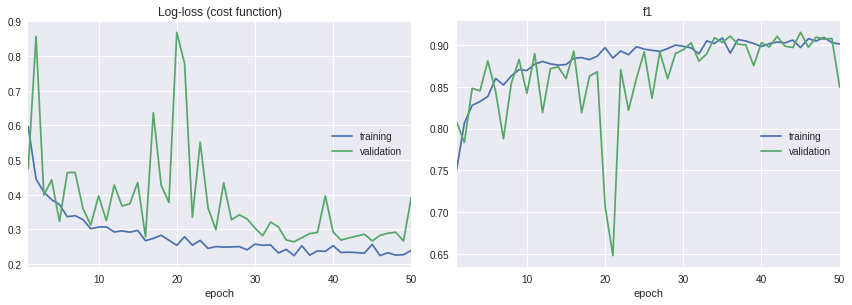

Epoch: 1 - Train loss: 0.596642  -  Train F1: 0.750226  - Validation loss: 0.475218  -  Validation F1: 0.808121
Epoch: 2 - Train loss: 0.445534  -  Train F1: 0.806443  - Validation loss: 0.856365  -  Validation F1: 0.783356
Epoch: 3 - Train loss: 0.407345  -  Train F1: 0.827832  - Validation loss: 0.398898  -  Validation F1: 0.848228
Epoch: 4 - Train loss: 0.385412  -  Train F1: 0.832296  - Validation loss: 0.442739  -  Validation F1: 0.845135
Epoch: 5 - Train loss: 0.371631  -  Train F1: 0.838461  - Validation loss: 0.322980  -  Validation F1: 0.880991
Epoch: 6 - Train loss: 0.336551  -  Train F1: 0.860093  - Validation loss: 0.463593  -  Validation F1: 0.844547
Epoch: 7 - Train loss: 0.339473  -  Train F1: 0.852200  - Validation loss: 0.464383  -  Validation F1: 0.787800
Epoch: 8 - Train loss: 0.328358  -  Train F1: 0.862990  - Validation loss: 0.360720  -  Validation F1: 0.854073
Epoch: 9 - Train loss: 0.301777  -  Train F1: 0.870643  - Validation loss: 0.312471  -  Validation F1: 0

In [21]:
# First 50 epochs
from livelossplot import PlotLossesKeras
import numpy as np
#                batch_size specified at train_generator
(model.fit_generator(train_generator, steps_per_epoch = np.floor(len(train_x) / BATCH_SIZE), 
                     epochs = 50, 
#                      workers = 4, 
                     verbose = 2,
                     max_queue_size = 2,
                     use_multiprocessing = True,
                     validation_data=dev_generator,
                     callbacks=[PlotLossesKeras(), LogCallback()]
                    ))

In [0]:
model.save('./first_model2_1.h5')
files.download('./first_model2_1.h5') 

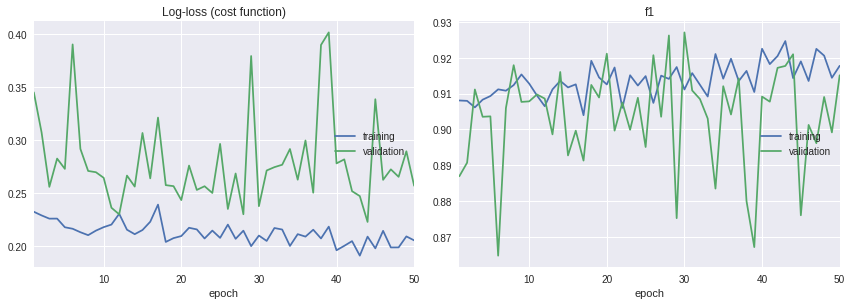

Epoch: 1 - Train loss: 0.232580  -  Train F1: 0.908063  - Validation loss: 0.344817  -  Validation F1: 0.886962
Epoch: 2 - Train loss: 0.229143  -  Train F1: 0.907959  - Validation loss: 0.307134  -  Validation F1: 0.890742
Epoch: 3 - Train loss: 0.226112  -  Train F1: 0.906141  - Validation loss: 0.255999  -  Validation F1: 0.911131
Epoch: 4 - Train loss: 0.226152  -  Train F1: 0.908286  - Validation loss: 0.282580  -  Validation F1: 0.903527
Epoch: 5 - Train loss: 0.218014  -  Train F1: 0.909302  - Validation loss: 0.272899  -  Validation F1: 0.903641
Epoch: 6 - Train loss: 0.216598  -  Train F1: 0.911170  - Validation loss: 0.389909  -  Validation F1: 0.864851
Epoch: 7 - Train loss: 0.213341  -  Train F1: 0.910786  - Validation loss: 0.291689  -  Validation F1: 0.905966
Epoch: 8 - Train loss: 0.210572  -  Train F1: 0.912356  - Validation loss: 0.270938  -  Validation F1: 0.917897
Epoch: 9 - Train loss: 0.214848  -  Train F1: 0.915319  - Validation loss: 0.269753  -  Validation F1: 0

In [19]:
from keras.models import load_model

model = load_model('./first_model2_1.h5', custom_objects={'f1': f1})

# Second 50 epochs
from livelossplot import PlotLossesKeras
import numpy as np
#                batch_size specified at train_generator
(model.fit_generator(train_generator, steps_per_epoch = np.floor(len(train_x) / BATCH_SIZE), 
                     epochs = 50, 
#                      workers = 4, 
                     verbose = 2,
                     max_queue_size = 2,
                     use_multiprocessing = True,
                     validation_data=dev_generator,
                     callbacks=[PlotLossesKeras(), LogCallback()]
                    ))

In [0]:
model.save('./first_model2_2.h5')
files.download('./first_model2_2.h5') 

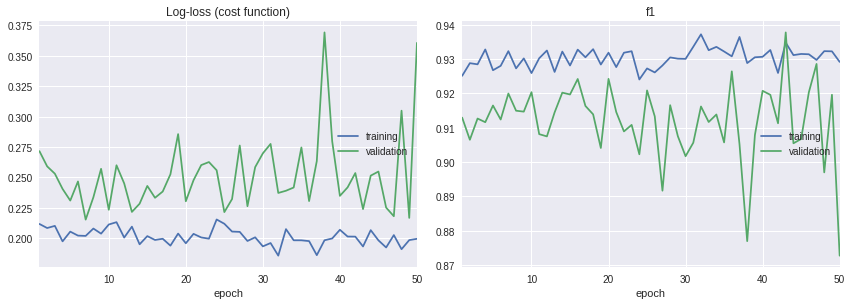

Epoch: 1 - Train loss: 0.211764  -  Train F1: 0.925089  - Validation loss: 0.271629  -  Validation F1: 0.912908
Epoch: 2 - Train loss: 0.208423  -  Train F1: 0.928775  - Validation loss: 0.259140  -  Validation F1: 0.906463
Epoch: 3 - Train loss: 0.210192  -  Train F1: 0.928438  - Validation loss: 0.253115  -  Validation F1: 0.912643
Epoch: 4 - Train loss: 0.197450  -  Train F1: 0.932771  - Validation loss: 0.240609  -  Validation F1: 0.911579
Epoch: 5 - Train loss: 0.205469  -  Train F1: 0.926721  - Validation loss: 0.231001  -  Validation F1: 0.916442
Epoch: 6 - Train loss: 0.202198  -  Train F1: 0.927998  - Validation loss: 0.246720  -  Validation F1: 0.912356
Epoch: 7 - Train loss: 0.201947  -  Train F1: 0.932273  - Validation loss: 0.215347  -  Validation F1: 0.919933
Epoch: 8 - Train loss: 0.208000  -  Train F1: 0.927262  - Validation loss: 0.233713  -  Validation F1: 0.914924
Epoch: 9 - Train loss: 0.203800  -  Train F1: 0.930165  - Validation loss: 0.257122  -  Validation F1: 0

In [18]:
from keras.models import load_model

model = load_model('./first_model2_2.h5', custom_objects={'f1': f1})

# Third 50 epochs
from livelossplot import PlotLossesKeras
import numpy as np
#                batch_size specified at train_generator
(model.fit_generator(train_generator, steps_per_epoch = np.floor(len(train_x) / BATCH_SIZE), 
                     epochs = 50, 
#                      workers = 4, 
                     verbose = 2,
                     max_queue_size = 2,
                     use_multiprocessing = True,
                     validation_data=dev_generator,
                     callbacks=[PlotLossesKeras(), LogCallback()]
                    ))

In [0]:
model.save('./first_model2_3.h5')
files.download('./first_model2_3.h5') 

After 150 epochs I draw the following conclusions:
- I don't like the big oscilations for the dev set in the metric and loss graph 
- Drop-out might be placed in the wrong positions (it's applied on the input instead of a layer).
- The output variable distribution is slightly different on dev set than on training set. Classes are not too unbalanced but maybe a small difference is enough to make the dev set not to perform closely to train loss and metric.
- Image augmentation (zoom and rotation) make the NN less prone to overfit.
- Gradients might be exploding. (https://machinelearningmastery.com/exploding-gradients-in-neural-networks/ 
http://cs231n.github.io/neural-networks-2/#reg)

Third model: now dropout (0.3) is placed before the dense layer, classes balanced in dev set too, gradient clipping in convolutional layer:

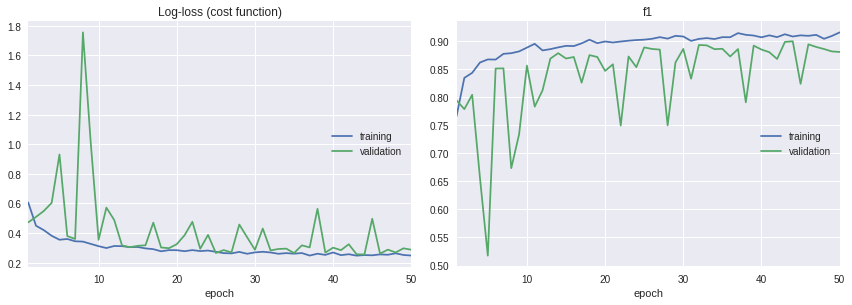

Epoch: 1 - Train loss: 0.606670  -  Train F1: 0.765811  - Validation loss: 0.471965  -  Validation F1: 0.793919
Epoch: 2 - Train loss: 0.449529  -  Train F1: 0.833973  - Validation loss: 0.508973  -  Validation F1: 0.778303
Epoch: 3 - Train loss: 0.419508  -  Train F1: 0.842906  - Validation loss: 0.549256  -  Validation F1: 0.803893
Epoch: 4 - Train loss: 0.381646  -  Train F1: 0.861344  - Validation loss: 0.603545  -  Validation F1: 0.655462
Epoch: 5 - Train loss: 0.354937  -  Train F1: 0.866785  - Validation loss: 0.930495  -  Validation F1: 0.517589
Epoch: 6 - Train loss: 0.359851  -  Train F1: 0.866570  - Validation loss: 0.379533  -  Validation F1: 0.850555
Epoch: 7 - Train loss: 0.344517  -  Train F1: 0.876719  - Validation loss: 0.360064  -  Validation F1: 0.850846
Epoch: 8 - Train loss: 0.342295  -  Train F1: 0.877894  - Validation loss: 1.754488  -  Validation F1: 0.673265
Epoch: 9 - Train loss: 0.326836  -  Train F1: 0.881056  - Validation loss: 1.008420  -  Validation F1: 0

In [41]:
# First 50 epochs
from livelossplot import PlotLossesKeras
import numpy as np
#                batch_size specified at train_generator
(model.fit_generator(train_generator, steps_per_epoch = np.floor(len(train_x) / BATCH_SIZE), 
                     epochs = 50, 
#                      workers = 4, 
                     verbose = 2,
                     max_queue_size = 2,
                     use_multiprocessing = True,
                     validation_data=dev_generator,
                     callbacks=[PlotLossesKeras(), LogCallback()]
                    ))

In [0]:
model.save('./first_model3_1.h5')
files.download('./first_model3_1.h5') 

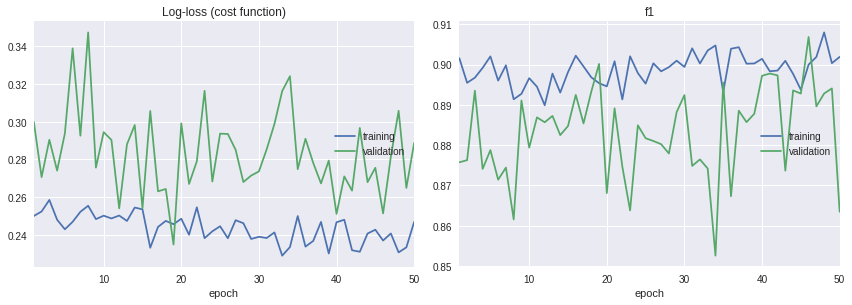

Epoch: 1 - Train loss: 0.250023  -  Train F1: 0.901553  - Validation loss: 0.299908  -  Validation F1: 0.875745
Epoch: 2 - Train loss: 0.252404  -  Train F1: 0.895461  - Validation loss: 0.270620  -  Validation F1: 0.876271
Epoch: 3 - Train loss: 0.258522  -  Train F1: 0.896728  - Validation loss: 0.290428  -  Validation F1: 0.893507
Epoch: 4 - Train loss: 0.248059  -  Train F1: 0.899163  - Validation loss: 0.274098  -  Validation F1: 0.874100
Epoch: 5 - Train loss: 0.242969  -  Train F1: 0.902011  - Validation loss: 0.293808  -  Validation F1: 0.878766
Epoch: 6 - Train loss: 0.246926  -  Train F1: 0.896013  - Validation loss: 0.338929  -  Validation F1: 0.871431
Epoch: 7 - Train loss: 0.252241  -  Train F1: 0.899803  - Validation loss: 0.292560  -  Validation F1: 0.874427
Epoch: 8 - Train loss: 0.255449  -  Train F1: 0.891371  - Validation loss: 0.347358  -  Validation F1: 0.861582
Epoch: 9 - Train loss: 0.248362  -  Train F1: 0.892724  - Validation loss: 0.275660  -  Validation F1: 0

In [21]:
# Second 50 epochs
from livelossplot import PlotLossesKeras
import numpy as np

from keras.models import load_model
model = load_model('./first_model3_1.h5', custom_objects={'f1': f1})

#                batch_size specified at train_generator
(model.fit_generator(train_generator, steps_per_epoch = np.floor(len(train_x) / BATCH_SIZE), 
                     epochs = 50, 
#                      workers = 4, 
                     verbose = 2,
                     max_queue_size = 2,
                     use_multiprocessing = True,
                     validation_data=dev_generator,
                     callbacks=[PlotLossesKeras(), LogCallback()]
                    ))

In [0]:
model.save('./first_model3_2.h5')
files.download('./first_model3_2.h5') 

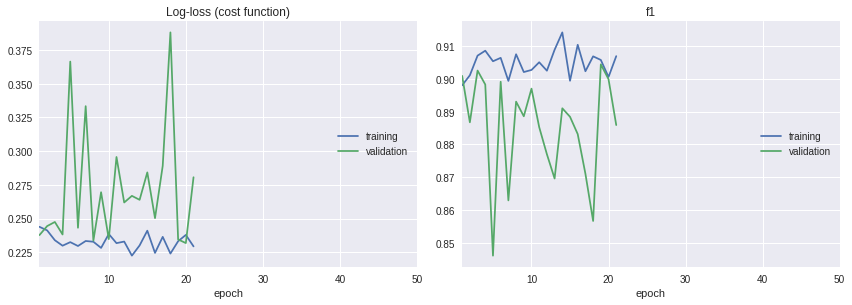

Epoch: 1 - Train loss: 0.243837  -  Train F1: 0.898073  - Validation loss: 0.237710  -  Validation F1: 0.900950
Epoch: 2 - Train loss: 0.241182  -  Train F1: 0.901141  - Validation loss: 0.244385  -  Validation F1: 0.886765
Epoch: 3 - Train loss: 0.233898  -  Train F1: 0.907147  - Validation loss: 0.247424  -  Validation F1: 0.902582
Epoch: 4 - Train loss: 0.229851  -  Train F1: 0.908655  - Validation loss: 0.238148  -  Validation F1: 0.898316
Epoch: 5 - Train loss: 0.232483  -  Train F1: 0.905430  - Validation loss: 0.366297  -  Validation F1: 0.846003
Epoch: 6 - Train loss: 0.229619  -  Train F1: 0.906470  - Validation loss: 0.243122  -  Validation F1: 0.899163
Epoch: 7 - Train loss: 0.233330  -  Train F1: 0.899425  - Validation loss: 0.333286  -  Validation F1: 0.862887
Epoch: 8 - Train loss: 0.232772  -  Train F1: 0.907564  - Validation loss: 0.233562  -  Validation F1: 0.893086
Epoch: 9 - Train loss: 0.228216  -  Train F1: 0.902132  - Validation loss: 0.269480  -  Validation F1: 0

Process ForkPoolWorker-85:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/local/lib/python3.6/dist-packages/keras/preprocessing/image.py", line 1440, in _get_batches_of_transformed_samples
    x = self.image_data_generator.random_transform(x)
  File "/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py", line 401, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "/usr/local/lib/python3.6/dist-packages/keras/preprocessing/image.py", line 1034, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)


KeyboardInterrupt: ignored

  File "/usr/local/lib/python3.6/dist-packages/keras/preprocessing/image.py", line 911, in random_transform
    fill_mode=self.fill_mode, cval=self.cval)
  File "/usr/local/lib/python3.6/dist-packages/keras/preprocessing/image.py", line 264, in apply_transform
    cval=cval) for x_channel in x]
  File "/usr/local/lib/python3.6/dist-packages/keras/preprocessing/image.py", line 264, in <listcomp>
    cval=cval) for x_channel in x]
  File "/usr/local/lib/python3.6/dist-packages/scipy/ndimage/interpolation.py", line 470, in affine_transform
    output, order, mode, cval, None, None)
  File "/usr/local/lib/python3.6/dist-packages/scipy/ndimage/interpolation.py", line 132, in _geometric_transform
    order, mode, cval, extra_arguments, extra_keywords)
KeyboardInterrupt


In [28]:
# Third 50 epochs
from livelossplot import PlotLossesKeras
import numpy as np

from keras.models import load_model
model = load_model('./first_model3_2.h5', custom_objects={'f1': f1})

#                batch_size specified at train_generator
(model.fit_generator(train_generator, steps_per_epoch = np.floor(len(train_x) / BATCH_SIZE), 
                     epochs = 50, 
#                      workers = 4, 
                     verbose = 2,
                     max_queue_size = 2,
                     use_multiprocessing = True,
                     validation_data=dev_generator,
                     callbacks=[
                                PlotLossesKeras(), LogCallback() 
#                                 ,tbCallBack
                     ]
                    ))

I don't like what I'm seeing so I'll stop the training.

More things to try:
- Use less agressive drop-out
- Average pooling of 2 instead of 4
- Batch size increased from 32 to 128

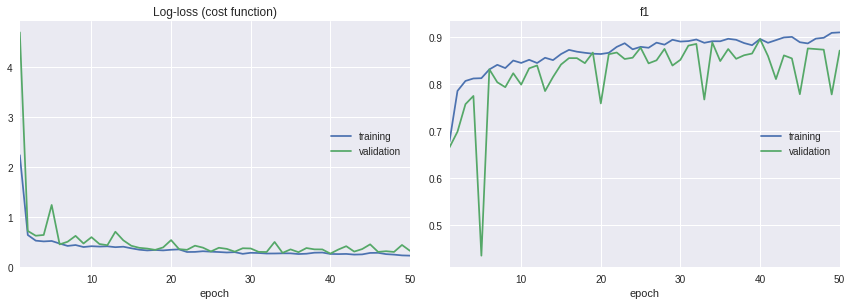

Epoch: 1 - Train loss: 2.235945  -  Train F1: 0.677705  - Validation loss: 4.691746  -  Validation F1: 0.664878 - 2018-08-06 06:22:55
Epoch: 2 - Train loss: 0.640004  -  Train F1: 0.784879  - Validation loss: 0.720929  -  Validation F1: 0.698172 - 2018-08-06 06:32:34
Epoch: 3 - Train loss: 0.526670  -  Train F1: 0.806075  - Validation loss: 0.625165  -  Validation F1: 0.756626 - 2018-08-06 06:42:11
Epoch: 4 - Train loss: 0.511531  -  Train F1: 0.811339  - Validation loss: 0.640722  -  Validation F1: 0.774156 - 2018-08-06 06:51:39
Epoch: 5 - Train loss: 0.520247  -  Train F1: 0.811924  - Validation loss: 1.240495  -  Validation F1: 0.434448 - 2018-08-06 07:01:05
Epoch: 6 - Train loss: 0.468967  -  Train F1: 0.830529  - Validation loss: 0.452444  -  Validation F1: 0.830793 - 2018-08-06 07:10:21
Epoch: 7 - Train loss: 0.421463  -  Train F1: 0.840408  - Validation loss: 0.505009  -  Validation F1: 0.803284 - 2018-08-06 07:19:34
Epoch: 8 - Train loss: 0.439355  -  Train F1: 0.833463  - Vali

In [21]:
# First 50 epochs
from livelossplot import PlotLossesKeras
import numpy as np

#                batch_size specified at train_generator
(model.fit_generator(train_generator, steps_per_epoch = np.floor(len(train_x) / BATCH_SIZE), 
                     epochs = 50, 
#                      workers = 4, 
                     verbose = 2,
                     max_queue_size = 2,
                     use_multiprocessing = True,
                     validation_data=dev_generator,
                     callbacks=[PlotLossesKeras(), LogCallback()]
                    ))

In [0]:
model.save('./first_model4_1.h5')
files.download('./first_model4_1.h5')

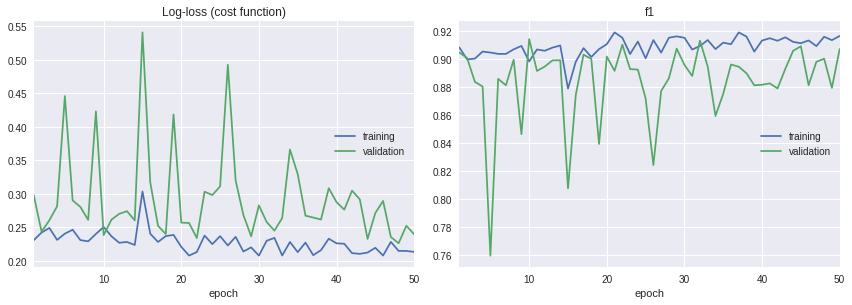

Epoch: 1 - Train loss: 0.230863  -  Train F1: 0.908492  - Validation loss: 0.297611  -  Validation F1: 0.904868 - 2018-08-07 20:48:01
Epoch: 2 - Train loss: 0.242157  -  Train F1: 0.899975  - Validation loss: 0.243250  -  Validation F1: 0.900975 - 2018-08-07 20:58:44
Epoch: 3 - Train loss: 0.249049  -  Train F1: 0.900535  - Validation loss: 0.260493  -  Validation F1: 0.883965 - 2018-08-07 21:09:26
Epoch: 4 - Train loss: 0.231204  -  Train F1: 0.905583  - Validation loss: 0.281365  -  Validation F1: 0.880641 - 2018-08-07 21:20:08
Epoch: 5 - Train loss: 0.240499  -  Train F1: 0.904876  - Validation loss: 0.445954  -  Validation F1: 0.759897 - 2018-08-07 21:30:53
Epoch: 6 - Train loss: 0.246360  -  Train F1: 0.903928  - Validation loss: 0.290173  -  Validation F1: 0.886081 - 2018-08-07 21:41:42
Epoch: 7 - Train loss: 0.230870  -  Train F1: 0.903914  - Validation loss: 0.280409  -  Validation F1: 0.881520 - 2018-08-07 21:52:22
Epoch: 8 - Train loss: 0.229059  -  Train F1: 0.907160  - Vali

In [21]:
# Second 50 epochs
from livelossplot import PlotLossesKeras
import numpy as np

from keras.models import load_model
model = load_model('./first_model4_1.h5', custom_objects={'f1': f1})

#                batch_size specified at train_generator
(model.fit_generator(train_generator, steps_per_epoch = np.floor(len(train_x) / BATCH_SIZE), 
                     epochs = 50, 
#                      workers = 4, 
                     verbose = 2,
                     max_queue_size = 2,
                     use_multiprocessing = True,
                     validation_data=dev_generator,
                     callbacks=[PlotLossesKeras(), LogCallback()]
                    ))

In [0]:
model.save('./first_model4_2.h5')
files.download('./first_model4_2.h5')

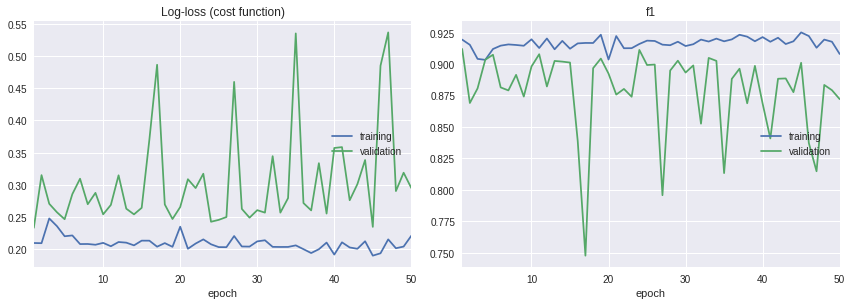

Epoch: 1 - Train loss: 0.209780  -  Train F1: 0.919423  - Validation loss: 0.233402  -  Validation F1: 0.911965 - 2018-08-09 06:24:43
Epoch: 2 - Train loss: 0.209510  -  Train F1: 0.915285  - Validation loss: 0.315170  -  Validation F1: 0.868999 - 2018-08-09 06:35:48
Epoch: 3 - Train loss: 0.247921  -  Train F1: 0.904090  - Validation loss: 0.270692  -  Validation F1: 0.880631 - 2018-08-09 06:46:59
Epoch: 4 - Train loss: 0.235976  -  Train F1: 0.903327  - Validation loss: 0.257551  -  Validation F1: 0.903396 - 2018-08-09 06:57:46
Epoch: 5 - Train loss: 0.220285  -  Train F1: 0.911952  - Validation loss: 0.246705  -  Validation F1: 0.907381 - 2018-08-09 07:08:32
Epoch: 6 - Train loss: 0.221541  -  Train F1: 0.914613  - Validation loss: 0.285698  -  Validation F1: 0.881389 - 2018-08-09 07:19:14
Epoch: 7 - Train loss: 0.208149  -  Train F1: 0.915598  - Validation loss: 0.309588  -  Validation F1: 0.879015 - 2018-08-09 07:29:52
Epoch: 8 - Train loss: 0.208268  -  Train F1: 0.915156  - Vali

In [19]:
# Third 50 epochs
from livelossplot import PlotLossesKeras
import numpy as np

from keras.models import load_model
model = load_model('./first_model4_2.h5', custom_objects={'f1': f1})

#                batch_size specified at train_generator
(model.fit_generator(train_generator, steps_per_epoch = np.floor(len(train_x) / BATCH_SIZE), 
                     epochs = 50, 
#                      workers = 4, 
                     verbose = 2,
                     max_queue_size = 2,
                     use_multiprocessing = True,
                     validation_data=dev_generator,
                     callbacks=[PlotLossesKeras(), LogCallback()]
                    ))

In [0]:
model.save('./first_model4_3.h5')
files.download('./first_model4_3.h5')

Weaker model:

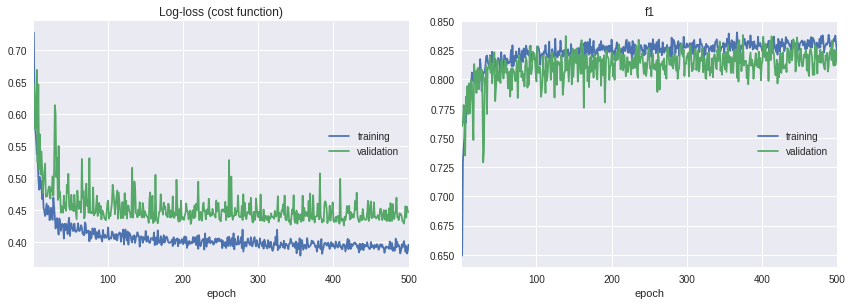

Epoch: 1 - Train loss: 0.727784  -  Train F1: 0.649228  - Validation loss: 0.647957  -  Validation F1: 0.759965 - 2018-08-14 06:19:32
Epoch: 2 - Train loss: 0.610530  -  Train F1: 0.729400  - Validation loss: 0.625259  -  Validation F1: 0.764084 - 2018-08-14 06:20:36
Epoch: 3 - Train loss: 0.575758  -  Train F1: 0.741916  - Validation loss: 0.576683  -  Validation F1: 0.778024 - 2018-08-14 06:21:43
Epoch: 4 - Train loss: 0.561112  -  Train F1: 0.751174  - Validation loss: 0.602305  -  Validation F1: 0.766235 - 2018-08-14 06:22:43
Epoch: 5 - Train loss: 0.537754  -  Train F1: 0.765094  - Validation loss: 0.669202  -  Validation F1: 0.734860 - 2018-08-14 06:23:44
Epoch: 6 - Train loss: 0.536479  -  Train F1: 0.762806  - Validation loss: 0.524885  -  Validation F1: 0.785197 - 2018-08-14 06:24:51
Epoch: 7 - Train loss: 0.501769  -  Train F1: 0.779106  - Validation loss: 0.646558  -  Validation F1: 0.774092 - 2018-08-14 06:25:57
Epoch: 8 - Train loss: 0.482090  -  Train F1: 0.780444  - Vali

In [21]:
from livelossplot import PlotLossesKeras
import numpy as np

#                batch_size specified at train_generator
(model.fit_generator(train_generator, steps_per_epoch = np.floor(6152 / BATCH_SIZE), 
                     epochs = 500, 
#                      workers = 4, 
                     verbose = 2,
                     max_queue_size = 2,
                     use_multiprocessing = False,
                     validation_data=dev_generator,
                     callbacks=[PlotLossesKeras(), LogCallback()]
                    ))

In [0]:
model.save('./first_model5.h5')
files.download('./first_model5.h5') 

I liked the learning curves of the previous model: let's try to improve that model a little bit.

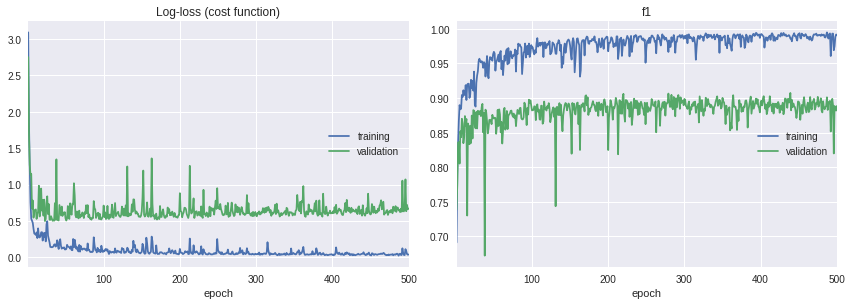

Epoch: 1 - Train loss: 3.091180  -  Train F1: 0.691334  - Validation loss: 2.750804  -  Validation F1: 0.738926 - 2018-08-14 18:17:50
Epoch: 2 - Train loss: 1.858372  -  Train F1: 0.791275  - Validation loss: 1.698783  -  Validation F1: 0.775049 - 2018-08-14 18:18:52
Epoch: 3 - Train loss: 1.251793  -  Train F1: 0.833171  - Validation loss: 1.271130  -  Validation F1: 0.835753 - 2018-08-14 18:19:59
Epoch: 4 - Train loss: 0.754778  -  Train F1: 0.866620  - Validation loss: 1.133789  -  Validation F1: 0.836357 - 2018-08-14 18:21:06
Epoch: 5 - Train loss: 0.530740  -  Train F1: 0.889856  - Validation loss: 1.145181  -  Validation F1: 0.805368 - 2018-08-14 18:22:13
Epoch: 6 - Train loss: 0.502376  -  Train F1: 0.883754  - Validation loss: 0.668228  -  Validation F1: 0.852010 - 2018-08-14 18:23:21
Epoch: 7 - Train loss: 0.472870  -  Train F1: 0.884766  - Validation loss: 0.780476  -  Validation F1: 0.843471 - 2018-08-14 18:24:23
Epoch: 8 - Train loss: 0.389762  -  Train F1: 0.904464  - Vali

In [21]:
from livelossplot import PlotLossesKeras
import numpy as np

#                batch_size specified at train_generator
(model.fit_generator(train_generator, steps_per_epoch = np.floor(6152 / BATCH_SIZE), 
                     epochs = 500, 
#                      workers = 4, 
                     verbose = 2,
                     max_queue_size = 2,
                     use_multiprocessing = False,
                     validation_data=dev_generator,
                     callbacks=[PlotLossesKeras(), LogCallback()]
                    ))

In [0]:
model.save('./first_model6.h5')
files.download('./first_model6.h5') 

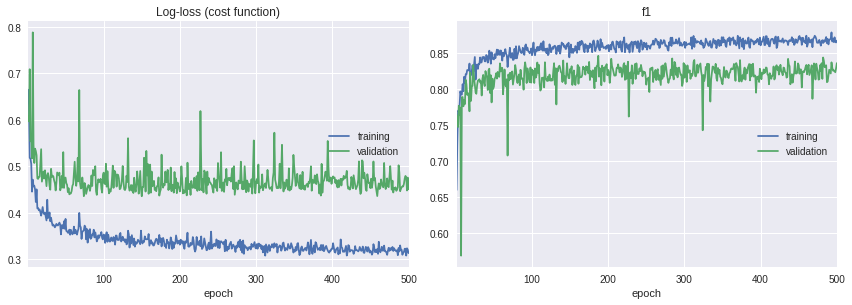

Epoch: 1 - Train loss: 0.664901  -  Train F1: 0.659326  - Validation loss: 0.608728  -  Validation F1: 0.751011 - 2018-08-18 22:26:45
Epoch: 2 - Train loss: 0.631946  -  Train F1: 0.723889  - Validation loss: 0.596744  -  Validation F1: 0.762281 - 2018-08-18 22:27:46
Epoch: 3 - Train loss: 0.518321  -  Train F1: 0.769484  - Validation loss: 0.709104  -  Validation F1: 0.746819 - 2018-08-18 22:28:47
Epoch: 4 - Train loss: 0.516287  -  Train F1: 0.768658  - Validation loss: 0.553780  -  Validation F1: 0.776376 - 2018-08-18 22:29:48
Epoch: 5 - Train loss: 0.505218  -  Train F1: 0.776818  - Validation loss: 0.563372  -  Validation F1: 0.763797 - 2018-08-18 22:30:49
Epoch: 6 - Train loss: 0.445518  -  Train F1: 0.796280  - Validation loss: 0.517272  -  Validation F1: 0.774021 - 2018-08-18 22:31:49
Epoch: 7 - Train loss: 0.471310  -  Train F1: 0.791596  - Validation loss: 0.788440  -  Validation F1: 0.568159 - 2018-08-18 22:32:50
Epoch: 8 - Train loss: 0.456808  -  Train F1: 0.791917  - Vali

In [19]:
from livelossplot import PlotLossesKeras
import numpy as np

#                batch_size specified at train_generator
(model.fit_generator(train_generator, steps_per_epoch = np.floor(6152 / BATCH_SIZE), 
                     epochs = 500, 
#                      workers = 4, 
                     verbose = 2,
                     max_queue_size = 2,
                     use_multiprocessing = False,
                     validation_data=dev_generator,
                     callbacks=[PlotLossesKeras(), LogCallback()]
                    ))

In [0]:
model.save('./first_model7.h5')
files.download('./first_model7.h5') 

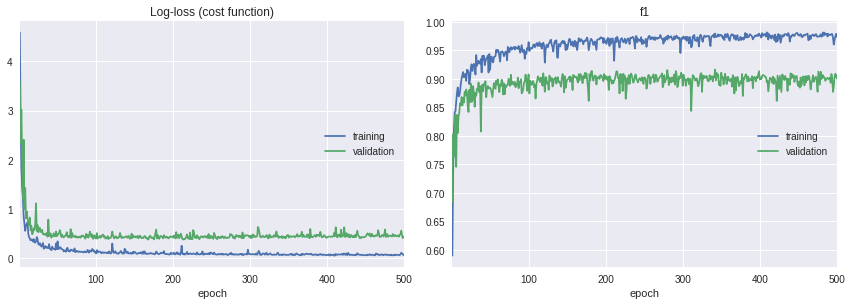

Epoch: 1 - Train loss: 4.583891  -  Train F1: 0.589916  - Validation loss: 3.589954  -  Validation F1: 0.684151 - 2018-08-19 12:18:31
Epoch: 2 - Train loss: 2.885602  -  Train F1: 0.732651  - Validation loss: 2.342717  -  Validation F1: 0.803111 - 2018-08-19 12:19:33
Epoch: 3 - Train loss: 1.847075  -  Train F1: 0.809266  - Validation loss: 3.013924  -  Validation F1: 0.763151 - 2018-08-19 12:20:35
Epoch: 4 - Train loss: 1.439170  -  Train F1: 0.840619  - Validation loss: 2.021879  -  Validation F1: 0.796582 - 2018-08-19 12:21:38
Epoch: 5 - Train loss: 1.229131  -  Train F1: 0.843017  - Validation loss: 1.212009  -  Validation F1: 0.836560 - 2018-08-19 12:22:40
Epoch: 6 - Train loss: 0.849085  -  Train F1: 0.860192  - Validation loss: 2.407337  -  Validation F1: 0.745637 - 2018-08-19 12:23:42
Epoch: 7 - Train loss: 0.710107  -  Train F1: 0.875214  - Validation loss: 1.002349  -  Validation F1: 0.836580 - 2018-08-19 12:24:44
Epoch: 8 - Train loss: 0.559964  -  Train F1: 0.884749  - Vali

In [33]:

from livelossplot import PlotLossesKeras
import numpy as np

#                batch_size specified at train_generator
(model.fit_generator(train_generator, steps_per_epoch = np.floor(6152 / BATCH_SIZE), 
                     epochs = 500, 
#                      workers = 4, 
                     verbose = 2,
                     max_queue_size = 2,
                     use_multiprocessing = False,
                     validation_data=dev_generator,
                     callbacks=[PlotLossesKeras(), LogCallback()]
                    ))

In [0]:
model.save('./first_model8.h5')
files.download('./first_model8.h5') 

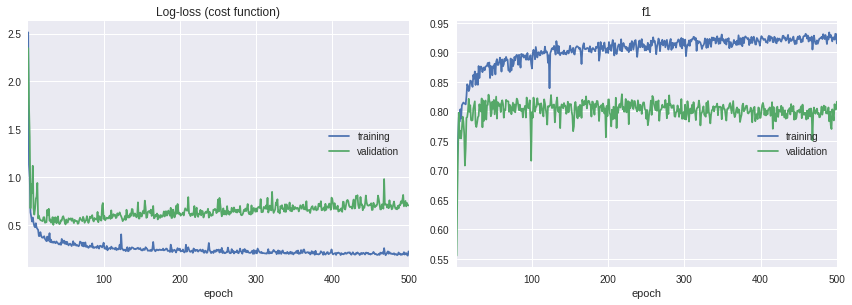

Epoch: 1 - Train loss: 2.511562  -  Train F1: 0.633907  - Validation loss: 2.345889  -  Validation F1: 0.554936 - 2018-08-23 06:26:27
Epoch: 2 - Train loss: 1.128837  -  Train F1: 0.731020  - Validation loss: 1.760145  -  Validation F1: 0.658523 - 2018-08-23 06:27:33
Epoch: 3 - Train loss: 0.989283  -  Train F1: 0.751596  - Validation loss: 1.417833  -  Validation F1: 0.734165 - 2018-08-23 06:28:38
Epoch: 4 - Train loss: 0.628940  -  Train F1: 0.789913  - Validation loss: 0.669971  -  Validation F1: 0.797418 - 2018-08-23 06:29:43
Epoch: 5 - Train loss: 0.579440  -  Train F1: 0.782356  - Validation loss: 0.923756  -  Validation F1: 0.754684 - 2018-08-23 06:30:50
Epoch: 6 - Train loss: 0.531895  -  Train F1: 0.803481  - Validation loss: 0.826650  -  Validation F1: 0.766875 - 2018-08-23 06:31:55
Epoch: 7 - Train loss: 0.573653  -  Train F1: 0.787458  - Validation loss: 1.114692  -  Validation F1: 0.753923 - 2018-08-23 06:33:01
Epoch: 8 - Train loss: 0.520249  -  Train F1: 0.810207  - Vali

In [21]:
from livelossplot import PlotLossesKeras
import numpy as np

#                batch_size specified at train_generator
(model.fit_generator(train_generator, steps_per_epoch = np.floor(6152 / BATCH_SIZE), 
                     epochs = 500, 
#                      workers = 4, 
                     verbose = 2,
                     max_queue_size = 2,
                     use_multiprocessing = False,
                     validation_data=dev_generator,
                     callbacks=[PlotLossesKeras(), LogCallback()]
                    ))

In [0]:
model.save('./first_model9.h5')
files.download('./first_model9.h5') 

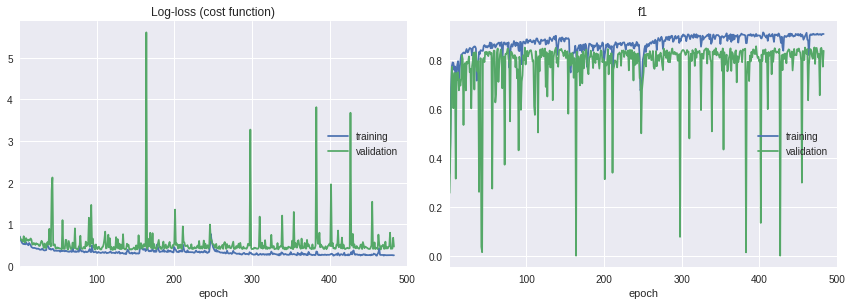

Epoch: 1 - Train loss: 0.710744  -  Train F1: 0.337664  - Validation loss: 0.690034  -  Validation F1: 0.257024 - 2018-08-26 22:55:21
Epoch: 2 - Train loss: 0.644197  -  Train F1: 0.462273  - Validation loss: 0.648988  -  Validation F1: 0.409653 - 2018-08-26 22:56:28
Epoch: 3 - Train loss: 0.591368  -  Train F1: 0.687224  - Validation loss: 0.625360  -  Validation F1: 0.629307 - 2018-08-26 22:57:33
Epoch: 4 - Train loss: 0.554517  -  Train F1: 0.776684  - Validation loss: 0.616250  -  Validation F1: 0.773839 - 2018-08-26 22:58:39
Epoch: 5 - Train loss: 0.535320  -  Train F1: 0.791919  - Validation loss: 0.584570  -  Validation F1: 0.724273 - 2018-08-26 22:59:43
Epoch: 6 - Train loss: 0.528733  -  Train F1: 0.789539  - Validation loss: 0.717615  -  Validation F1: 0.604290 - 2018-08-26 23:00:44
Epoch: 7 - Train loss: 0.548034  -  Train F1: 0.761192  - Validation loss: 0.596401  -  Validation F1: 0.748215 - 2018-08-26 23:01:45
Epoch: 8 - Train loss: 0.522576  -  Train F1: 0.775477  - Vali

In [0]:
from livelossplot import PlotLossesKeras
import numpy as np

#                batch_size specified at train_generator
(model.fit_generator(train_generator, steps_per_epoch = np.floor(6152 / BATCH_SIZE), 
                     epochs = 500, 
#                      workers = 4, 
                     verbose = 2,
                     max_queue_size = 2,
                     use_multiprocessing = False,
                     validation_data=dev_generator,
                     callbacks=[PlotLossesKeras(), LogCallback()]
                    ))

In [0]:
model.save('./first_model10.h5')
files.download('./first_model10.h5') 

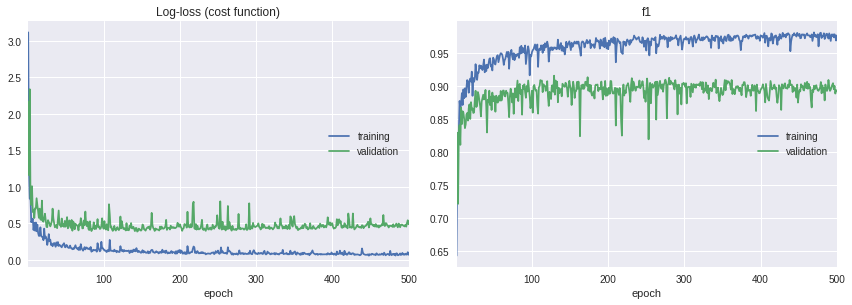

Epoch: 1 - Train loss: 3.113911  -  Train F1: 0.643688  - Validation loss: 2.163884  -  Validation F1: 0.738977 - 2018-08-29 22:31:11
Epoch: 2 - Train loss: 1.273506  -  Train F1: 0.807363  - Validation loss: 1.158940  -  Validation F1: 0.829537 - 2018-08-29 22:32:12
Epoch: 3 - Train loss: 0.836926  -  Train F1: 0.825129  - Validation loss: 2.335609  -  Validation F1: 0.722090 - 2018-08-29 22:33:14
Epoch: 4 - Train loss: 0.857437  -  Train F1: 0.830831  - Validation loss: 0.861448  -  Validation F1: 0.831985 - 2018-08-29 22:34:15
Epoch: 5 - Train loss: 0.513192  -  Train F1: 0.877855  - Validation loss: 0.751087  -  Validation F1: 0.841478 - 2018-08-29 22:35:17
Epoch: 6 - Train loss: 0.535572  -  Train F1: 0.863846  - Validation loss: 1.006168  -  Validation F1: 0.811444 - 2018-08-29 22:36:19
Epoch: 7 - Train loss: 0.562435  -  Train F1: 0.874630  - Validation loss: 0.653799  -  Validation F1: 0.867736 - 2018-08-29 22:37:21
Epoch: 8 - Train loss: 0.406201  -  Train F1: 0.889748  - Vali

In [20]:

from livelossplot import PlotLossesKeras
import numpy as np

#                batch_size specified at train_generator
(model.fit_generator(train_generator, steps_per_epoch = np.floor(6152 / BATCH_SIZE), 
                     epochs = 500, 
#                      workers = 4, 
                     verbose = 2,
                     max_queue_size = 2,
                     use_multiprocessing = False,
                     validation_data=dev_generator,
                     callbacks=[PlotLossesKeras(), LogCallback()]
                    ))

In [0]:
model.save('./first_model8Again.h5')
files.download('./first_model8Again.h5') 

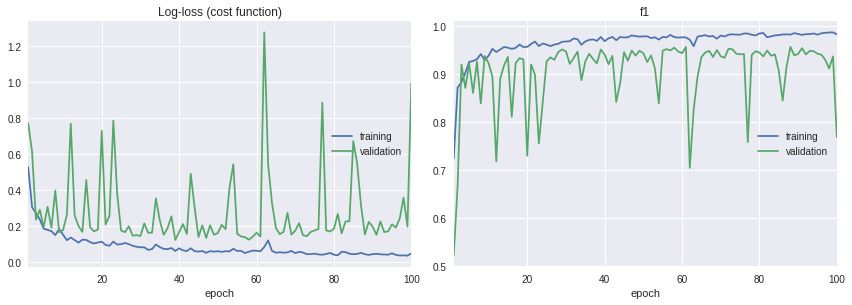

Epoch: 1 - Train loss: 0.527020  -  Train F1: 0.723173  - Validation loss: 0.771259  -  Validation F1: 0.521192 - 2018-09-09 14:07:00
Epoch: 2 - Train loss: 0.305127  -  Train F1: 0.871447  - Validation loss: 0.613962  -  Validation F1: 0.664720 - 2018-09-09 14:09:26
Epoch: 3 - Train loss: 0.271581  -  Train F1: 0.882418  - Validation loss: 0.235489  -  Validation F1: 0.919260 - 2018-09-09 14:11:52
Epoch: 4 - Train loss: 0.236987  -  Train F1: 0.902285  - Validation loss: 0.290952  -  Validation F1: 0.870438 - 2018-09-09 14:14:19
Epoch: 5 - Train loss: 0.185614  -  Train F1: 0.924885  - Validation loss: 0.193751  -  Validation F1: 0.921157 - 2018-09-09 14:16:46
Epoch: 6 - Train loss: 0.179052  -  Train F1: 0.926675  - Validation loss: 0.306818  -  Validation F1: 0.860001 - 2018-09-09 14:19:12
Epoch: 7 - Train loss: 0.171629  -  Train F1: 0.930364  - Validation loss: 0.190809  -  Validation F1: 0.925506 - 2018-09-09 14:21:38
Epoch: 8 - Train loss: 0.149862  -  Train F1: 0.941070  - Vali

In [15]:
from livelossplot import PlotLossesKeras
import numpy as np

#                batch_size specified at train_generator
(model.fit_generator(train_generator, steps_per_epoch = np.floor(6152 / BATCH_SIZE), 
                     epochs = 100, 
#                      workers = 4, 
                     verbose = 2,
                     max_queue_size = 2,
                     use_multiprocessing = False,
                     validation_data=dev_generator,
                     callbacks=[PlotLossesKeras(), LogCallback()]
                    ))

In [0]:

model.save('./first_model11.h5')
files.download('./first_model11.h5') 

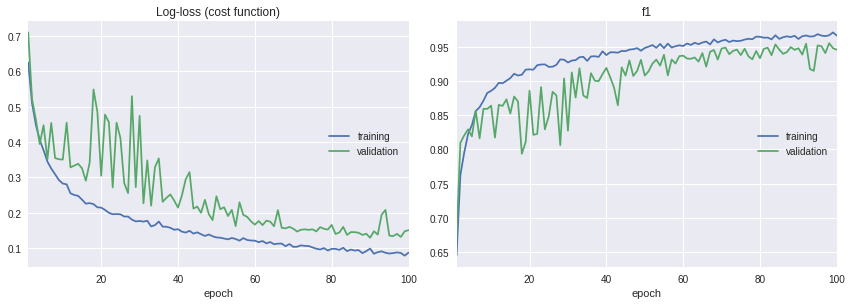

Epoch: 1 - Train loss: 0.624586  -  Train F1: 0.644681  - Validation loss: 0.709673  -  Validation F1: 0.669997 - 2018-09-09 18:17:27
Epoch: 2 - Train loss: 0.509527  -  Train F1: 0.762524  - Validation loss: 0.521066  -  Validation F1: 0.809585 - 2018-09-09 18:19:52
Epoch: 3 - Train loss: 0.448394  -  Train F1: 0.795305  - Validation loss: 0.463372  -  Validation F1: 0.820526 - 2018-09-09 18:22:16
Epoch: 4 - Train loss: 0.405592  -  Train F1: 0.822292  - Validation loss: 0.394340  -  Validation F1: 0.829196 - 2018-09-09 18:24:42
Epoch: 5 - Train loss: 0.376617  -  Train F1: 0.835608  - Validation loss: 0.447466  -  Validation F1: 0.818973 - 2018-09-09 18:27:08
Epoch: 6 - Train loss: 0.344826  -  Train F1: 0.856043  - Validation loss: 0.351090  -  Validation F1: 0.856502 - 2018-09-09 18:29:33
Epoch: 7 - Train loss: 0.324931  -  Train F1: 0.861629  - Validation loss: 0.453761  -  Validation F1: 0.816188 - 2018-09-09 18:31:58
Epoch: 8 - Train loss: 0.308843  -  Train F1: 0.871207  - Vali

In [22]:
# execute
from livelossplot import PlotLossesKeras
import numpy as np

#                batch_size specified at train_generator
(model.fit_generator(train_generator, steps_per_epoch = np.floor(6152 / BATCH_SIZE), 
                     epochs = 100, 
#                      workers = 4, 
                     verbose = 2,
                     max_queue_size = 2,
                     use_multiprocessing = False,
                     validation_data=dev_generator,
                     callbacks=[PlotLossesKeras(), LogCallback()]
                    ))

In [0]:
# execute
model.save('./first_model11_lr0dot0001_100epoch.h5')
files.download('./first_model11_lr0dot0001_100epoch.h5') 

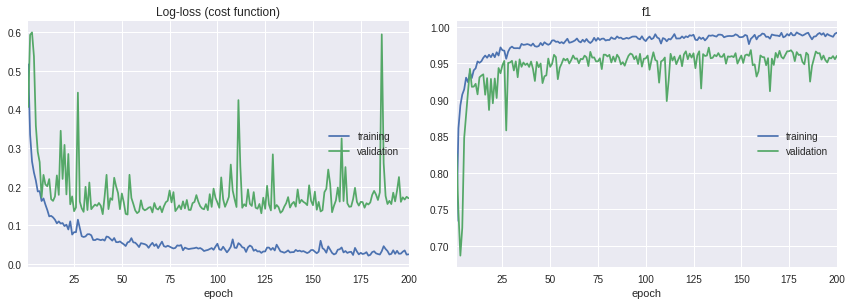

Epoch: 1 - Train loss: 0.517072  -  Train F1: 0.734113  - Validation loss: 0.406514  -  Validation F1: 0.825948 - 2018-09-11 18:22:36
Epoch: 2 - Train loss: 0.334845  -  Train F1: 0.860946  - Validation loss: 0.593667  -  Validation F1: 0.746259 - 2018-09-11 18:24:57
Epoch: 3 - Train loss: 0.265342  -  Train F1: 0.892208  - Validation loss: 0.600057  -  Validation F1: 0.686815 - 2018-09-11 18:27:18
Epoch: 4 - Train loss: 0.236728  -  Train F1: 0.907039  - Validation loss: 0.537955  -  Validation F1: 0.724871 - 2018-09-11 18:29:42
Epoch: 5 - Train loss: 0.215790  -  Train F1: 0.914066  - Validation loss: 0.358164  -  Validation F1: 0.847464 - 2018-09-11 18:32:02
Epoch: 6 - Train loss: 0.187476  -  Train F1: 0.930175  - Validation loss: 0.290037  -  Validation F1: 0.878548 - 2018-09-11 18:34:19
Epoch: 7 - Train loss: 0.188345  -  Train F1: 0.924016  - Validation loss: 0.263646  -  Validation F1: 0.910754 - 2018-09-11 18:36:39
Epoch: 8 - Train loss: 0.162777  -  Train F1: 0.937376  - Vali

In [19]:
# execute
from livelossplot import PlotLossesKeras
import numpy as np

#                batch_size specified at train_generator
(model.fit_generator(train_generator, steps_per_epoch = np.floor(6152 / BATCH_SIZE), 
                     epochs = 200, 
#                      workers = 4, 
                     verbose = 2,
                     max_queue_size = 2,
                     use_multiprocessing = False,
                     validation_data=dev_generator,
                     callbacks=[PlotLossesKeras(), LogCallback()]
                    ))

In [0]:
# execute
model.save('./first_model11_lr0dot001_decay1e-06_300epoch.h5')
files.download('./first_model11_lr0dot001_decay1e-06_300epoch.h5') 

Stop training at iteration 50?

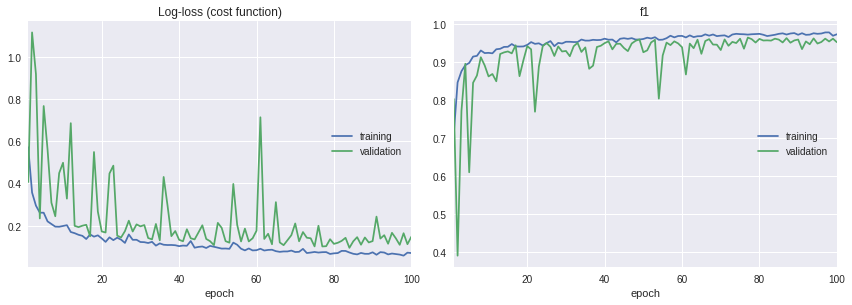

Epoch: 1 - Train loss: 0.571352  -  Train F1: 0.707611  - Validation loss: 0.406612  -  Validation F1: 0.801932 - 2018-09-17 06:28:01
Epoch: 2 - Train loss: 0.356665  -  Train F1: 0.845434  - Validation loss: 1.115716  -  Validation F1: 0.390769 - 2018-09-17 06:30:22
Epoch: 3 - Train loss: 0.294582  -  Train F1: 0.874863  - Validation loss: 0.917990  -  Validation F1: 0.770860 - 2018-09-17 06:32:43
Epoch: 4 - Train loss: 0.261370  -  Train F1: 0.890804  - Validation loss: 0.234090  -  Validation F1: 0.894597 - 2018-09-17 06:35:05
Epoch: 5 - Train loss: 0.261028  -  Train F1: 0.896597  - Validation loss: 0.766902  -  Validation F1: 0.609659 - 2018-09-17 06:37:26
Epoch: 6 - Train loss: 0.220049  -  Train F1: 0.913302  - Validation loss: 0.560964  -  Validation F1: 0.844565 - 2018-09-17 06:39:48
Epoch: 7 - Train loss: 0.207518  -  Train F1: 0.915176  - Validation loss: 0.308456  -  Validation F1: 0.863624 - 2018-09-17 06:42:11
Epoch: 8 - Train loss: 0.195152  -  Train F1: 0.929355  - Vali

In [20]:
# execute
from livelossplot import PlotLossesKeras
import numpy as np

#                batch_size specified at train_generator
(model.fit_generator(train_generator, steps_per_epoch = np.floor(6152 / BATCH_SIZE), 
                     epochs = 100, 
#                      workers = 4, 
                     verbose = 2,
                     max_queue_size = 2,
                     use_multiprocessing = False,
                     validation_data=dev_generator,
                     callbacks=[PlotLossesKeras(), LogCallback()]
                    ))

In [0]:
model.save('./first_model12.h5')
files.download('./first_model12.h5') 

# Asessing Models Performance

In [15]:
from keras.models import load_model
model8 = load_model('./models/first_model8Again.h5', custom_objects={'f1': f1})
model11A = load_model('./models/first_model11.h5', custom_objects={'f1': f1})
model11B = load_model('./models/first_model11_lr0dot0001_100epoch.h5', custom_objects={'f1': f1})
model11C = load_model('./models/first_model11_lr0dot001_decay1e-06_300epoch.h5', custom_objects={'f1': f1})
model12 = load_model('./models/first_model12.h5', custom_objects={'f1': f1})

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

def plot_roc_curve_and_best_thrs(true_y, pred_y):
  fpr, tpr, thresholds = roc_curve(true_y, pred_y)

  auc_val = auc(fpr, tpr)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr, label='(area = %.3f)' % auc_val)
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

  # Best threshold
  # i = np.arange(len(tpr)) 
  # roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(thresholds, index=i)})
  # roc_t = roc.loc[(roc.tf-0).abs().argsort()[:1]]
  # print(roc_t['threshold'])

  print('Best threshold (max tpr - fpr): %f' % thresholds[ np.argmax(tpr - fpr) ])
  # https://cran.r-project.org/web/packages/pROC/pROC.pdf page 34, Best thresholds section
  # print('Best threshold (min (1 - tpr)^2 - (1 - tnr)^2): %f' % thresholds[ np.argmin( np.square(1 - tpr) + np.square(1 - (1 - fpr) )  ) ])

In [38]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np

datagen_no_tr = ImageDataGenerator(data_format = 'channels_first')

test_generator = datagen_no_tr.flow_from_directory(
                            './test',
                            target_size = (480, 640),
                            batch_size = BATCH_SIZE,
                            class_mode = 'binary',
                            classes = ['home', 'out'],
                            shuffle = False)

dev_generator = datagen_no_tr.flow_from_directory(
                            './dev_transformed_images',
                            target_size = (480, 640),
                            batch_size = BATCH_SIZE,
                            class_mode = 'binary',
                            classes = ['home', 'out'],
                            shuffle = False)

train_generator = datagen_no_tr.flow_from_directory(
                            './train_transformed_images',
                            target_size = (480, 640),
                            batch_size = BATCH_SIZE,
                            class_mode = 'binary',
                            classes = ['home', 'out'],
                            shuffle = False)

y_test_preds_model8_train = model8.predict_generator(train_generator, verbose = 0, steps = 6152 / BATCH_SIZE)
y_test_preds_model11A_train = model11A.predict_generator(train_generator, verbose = 0, steps = 6152 / BATCH_SIZE)
y_test_preds_model11B_train = model11B.predict_generator(train_generator, verbose = 0, steps = 6152 / BATCH_SIZE)
y_test_preds_model11C_train = model11C.predict_generator(train_generator, verbose = 0, steps = 6152 / BATCH_SIZE)
y_test_preds_model12_train = model12.predict_generator(train_generator, verbose = 0, steps = 6152 / BATCH_SIZE)

y_test_preds_model8 = model8.predict_generator(test_generator, verbose = 0, steps = 1005 / BATCH_SIZE)
y_test_preds_model11A = model11A.predict_generator(test_generator, verbose = 0, steps = 1005 / BATCH_SIZE)
y_test_preds_model11B = model11B.predict_generator(test_generator, verbose = 0, steps = 1005 / BATCH_SIZE)
y_test_preds_model11C = model11C.predict_generator(test_generator, verbose = 0, steps = 1005 / BATCH_SIZE)
y_test_preds_model12 = model12.predict_generator(test_generator, verbose = 0, steps = 1005 / BATCH_SIZE)

y_test_preds_model8_dev = model8.predict_generator(dev_generator, verbose = 0, steps = 855 / BATCH_SIZE)
y_test_preds_model11A_dev = model11A.predict_generator(dev_generator, verbose = 0, steps = 855 / BATCH_SIZE)
y_test_preds_model11B_dev = model11B.predict_generator(dev_generator, verbose = 0, steps = 855 / BATCH_SIZE)
y_test_preds_model11C_dev = model11C.predict_generator(dev_generator, verbose = 0, steps = 855 / BATCH_SIZE)
y_test_preds_model12_dev = model12.predict_generator(dev_generator, verbose = 0, steps = 855 / BATCH_SIZE)

def predicted_report(y_test, y_pred):
    print('%s\n' % pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))

    print('Accuracy: %f\n' % accuracy_score(y_test, y_pred))

    print(classification_report(y_test, y_pred))

Found 1004 images belonging to 2 classes.
Found 855 images belonging to 2 classes.


##Model 8

In [55]:
model8.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 480, 640)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 480, 640)       8         
_________________________________________________________________
bn1 (BatchNormalization)     (None, 2, 480, 640)       8         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2, 480, 640)       0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 2, 240, 320)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 153600)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 153600)            0         
__________

Train set:

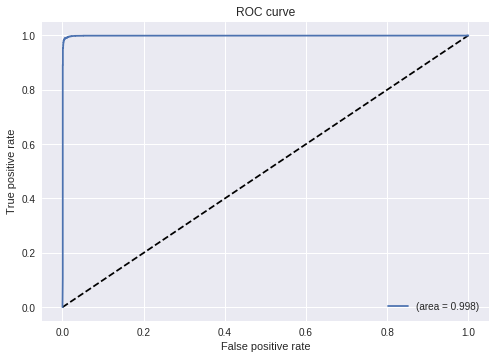

Best threshold (max tpr - fpr): 0.283182


In [22]:
plot_roc_curve_and_best_thrs(1 - train_generator.classes, y_test_preds_model8_train.ravel())

In [23]:
results_to_vals = np.vectorize(lambda x: 'home' if x < 0.283182 else 'out')

predicted_report(results_to_vals(1 - train_generator.classes), results_to_vals(y_test_preds_model8_train.flatten()))

# Notes: lower precision -> more false positives. lower recall -> more false negatives
# In our case, we're interested in the recall metric: we want to avoid cases where the system says Pépito is at home and he's actually outside
#(we want to avoid false negatives)
# In predicted_report, each metric on each row means that metric's been calculated using that label as the positive class

Predicted  home   out   All
Actual                     
home       3060    20  3080
out          31  3041  3072
All        3091  3061  6152

Accuracy: 0.991710

             precision    recall  f1-score   support

       home       0.99      0.99      0.99      3080
        out       0.99      0.99      0.99      3072

avg / total       0.99      0.99      0.99      6152



Dev set:

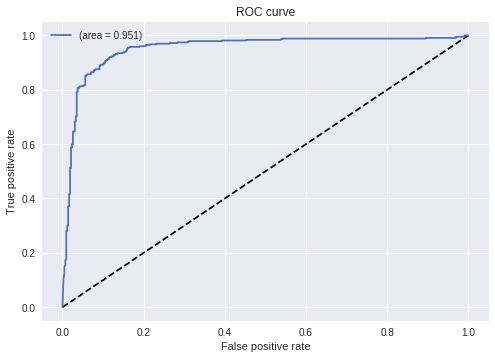

Best threshold (max tpr - fpr): 0.130351


In [40]:
plot_roc_curve_and_best_thrs(1 - dev_generator.classes, y_test_preds_model8_dev.ravel())

In [50]:
results_to_vals = np.vectorize(lambda x: 'home' if x < 0.130351 else 'out')

predicted_report(results_to_vals(1 - dev_generator.classes), results_to_vals(y_test_preds_model8_dev.flatten()))

# Notes: lower precision -> more false positives. lower recall -> more false negatives
# In our case, we're interested in the recall metric: we want to avoid cases where the system says Pépito is at home and he's actually outside
#(we want to avoid false negatives)
# In predicted_report, each metric on each row means that metric's been calculated using that label as the positive class

Predicted  home  out  All
Actual                   
home        378   50  428
out          35  392  427
All         413  442  855

Accuracy: 0.900585

             precision    recall  f1-score   support

       home       0.92      0.88      0.90       428
        out       0.89      0.92      0.90       427

avg / total       0.90      0.90      0.90       855



Test set:

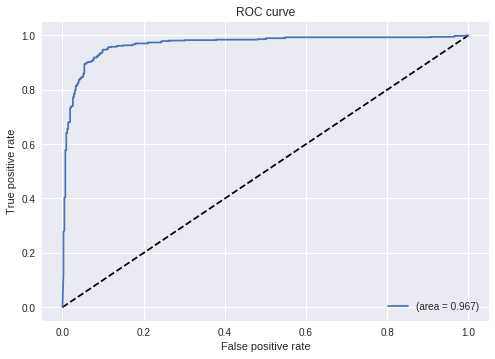

Best threshold (max tpr - fpr): 0.409025


In [90]:
plot_roc_curve_and_best_thrs(1 - test_generator.classes, y_test_preds_model8.ravel())

In [41]:
predicted_report(results_to_vals(1 - test_generator.classes), results_to_vals(y_test_preds_model8.flatten()))

# Notes: lower precision -> more false positives. lower recall -> more false negatives
# In our case, we're interested in the recall metric: we want to avoid cases where the system says Pépito is at home and he's actually outside
#(we want to avoid false negatives)
# In predicted_report, each metric on each row means that metric's been calculated using that label as the positive class

Predicted  home  out   All
Actual                    
home        369   59   428
out          22  554   576
All         391  613  1004

Accuracy: 0.919323

             precision    recall  f1-score   support

       home       0.94      0.86      0.90       428
        out       0.90      0.96      0.93       576

avg / total       0.92      0.92      0.92      1004



##Model 11A

In [56]:
model11A.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 480, 640)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 480, 640)       866       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 2, 480, 640)       8         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2, 480, 640)       0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 2, 240, 320)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 240, 320)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 4, 240, 320)       292       
__________

Train set:

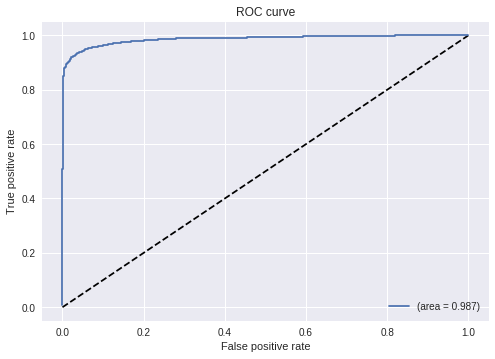

Best threshold (max tpr - fpr): 0.000251


In [24]:
plot_roc_curve_and_best_thrs(1 - train_generator.classes, y_test_preds_model11A_train.ravel())

In [27]:
results_to_vals = np.vectorize(lambda x: 'home' if x < 0.000251 else 'out')

predicted_report(results_to_vals(1 - train_generator.classes), results_to_vals(y_test_preds_model11A_train.flatten()))

# Notes: lower precision -> more false positives. lower recall -> more false negatives
# In our case, we're interested in the recall metric: we want to avoid cases where the system says Pépito is at home and he's actually outside
#(we want to avoid false negatives)
# In predicted_report, each metric on each row means that metric's been calculated using that label as the positive class

Predicted  home   out   All
Actual                     
home       3001    79  3080
out         235  2837  3072
All        3236  2916  6152

Accuracy: 0.948960

             precision    recall  f1-score   support

       home       0.93      0.97      0.95      3080
        out       0.97      0.92      0.95      3072

avg / total       0.95      0.95      0.95      6152



Dev set:

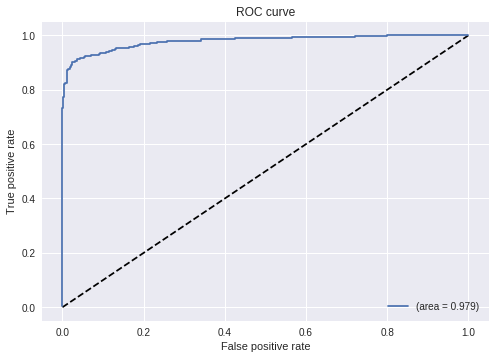

Best threshold (max tpr - fpr): 0.000473


In [42]:
plot_roc_curve_and_best_thrs(1 - dev_generator.classes, y_test_preds_model11A_dev.ravel())

In [51]:
results_to_vals = np.vectorize(lambda x: 'home' if x < 0.000473 else 'out')

predicted_report(results_to_vals(1 - dev_generator.classes), results_to_vals(y_test_preds_model11A_dev.flatten()))

# Notes: lower precision -> more false positives. lower recall -> more false negatives
# In our case, we're interested in the recall metric: we want to avoid cases where the system says Pépito is at home and he's actually outside
#(we want to avoid false negatives)
# In predicted_report, each metric on each row means that metric's been calculated using that label as the positive class

Predicted  home  out  All
Actual                   
home        413   15  428
out          38  389  427
All         451  404  855

Accuracy: 0.938012

             precision    recall  f1-score   support

       home       0.92      0.96      0.94       428
        out       0.96      0.91      0.94       427

avg / total       0.94      0.94      0.94       855



Test set:

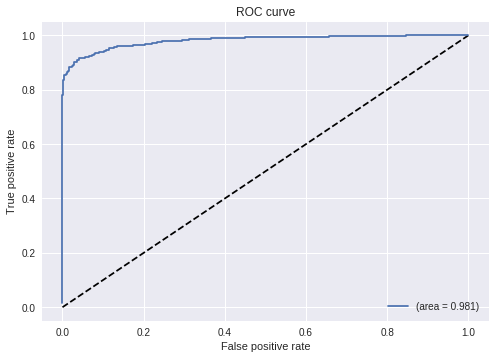

Best threshold (max tpr - fpr): 0.000315


In [93]:
plot_roc_curve_and_best_thrs(1 - test_generator.classes, y_test_preds_model11A.ravel())

In [43]:
predicted_report(results_to_vals(1 - test_generator.classes), results_to_vals(y_test_preds_model11A.flatten()))

# Notes: lower precision -> more false positives. lower recall -> more false negatives
# In our case, we're interested in the recall metric: we want to avoid cases where the system says Pépito is at home and he's actually outside
#(we want to avoid false negatives)
# In predicted_report, each metric on each row means that metric's been calculated using that label as the positive class

Predicted  home  out   All
Actual                    
home        413   15   428
out          53  523   576
All         466  538  1004

Accuracy: 0.932271

             precision    recall  f1-score   support

       home       0.89      0.96      0.92       428
        out       0.97      0.91      0.94       576

avg / total       0.94      0.93      0.93      1004



##Model 11B

In [57]:
model11B.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3, 480, 640)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 480, 640)       866       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 2, 480, 640)       8         
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 2, 480, 640)       0         
_________________________________________________________________
average_pooling2d_5 (Average (None, 2, 240, 320)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2, 240, 320)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 4, 240, 320)       292       
__________

Train set:

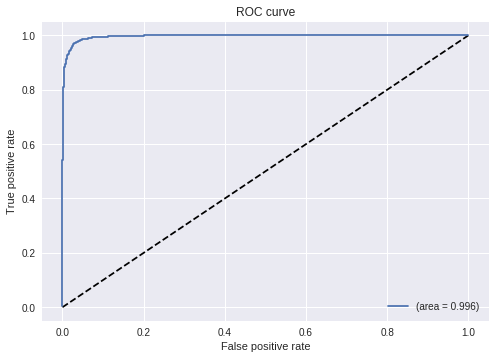

Best threshold (max tpr - fpr): 0.575829


In [26]:
plot_roc_curve_and_best_thrs(1 - train_generator.classes, y_test_preds_model11B_train.ravel())

In [28]:
results_to_vals = np.vectorize(lambda x: 'home' if x < 0.575829 else 'out')

predicted_report(results_to_vals(1 - train_generator.classes), results_to_vals(y_test_preds_model11B_train.flatten()))

# Notes: lower precision -> more false positives. lower recall -> more false negatives
# In our case, we're interested in the recall metric: we want to avoid cases where the system says Pépito is at home and he's actually outside
#(we want to avoid false negatives)
# In predicted_report, each metric on each row means that metric's been calculated using that label as the positive class

Predicted  home   out   All
Actual                     
home       2978   102  3080
out          77  2995  3072
All        3055  3097  6152

Accuracy: 0.970904

             precision    recall  f1-score   support

       home       0.97      0.97      0.97      3080
        out       0.97      0.97      0.97      3072

avg / total       0.97      0.97      0.97      6152



Dev set:

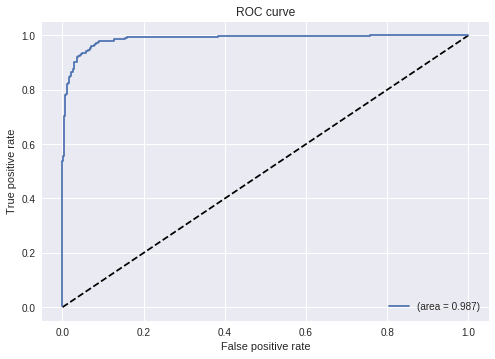

Best threshold (max tpr - fpr): 0.489785


In [44]:
plot_roc_curve_and_best_thrs(1 - dev_generator.classes, y_test_preds_model11B_dev.ravel())

In [52]:
results_to_vals = np.vectorize(lambda x: 'home' if x < 0.489785 else 'out')

predicted_report(results_to_vals(1 - dev_generator.classes), results_to_vals(y_test_preds_model11B_dev.flatten()))

# Notes: lower precision -> more false positives. lower recall -> more false negatives
# In our case, we're interested in the recall metric: we want to avoid cases where the system says Pépito is at home and he's actually outside
#(we want to avoid false negatives)
# In predicted_report, each metric on each row means that metric's been calculated using that label as the positive class

Predicted  home  out  All
Actual                   
home        398   30  428
out          17  410  427
All         415  440  855

Accuracy: 0.945029

             precision    recall  f1-score   support

       home       0.96      0.93      0.94       428
        out       0.93      0.96      0.95       427

avg / total       0.95      0.95      0.95       855



Test set:

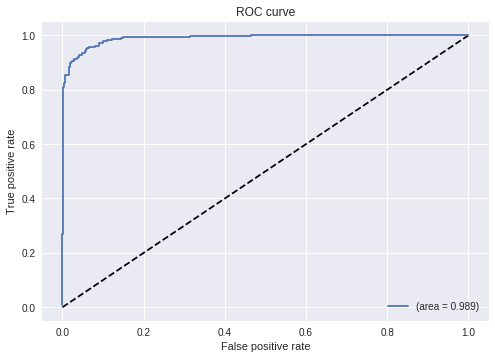

Best threshold (max tpr - fpr): 0.611514


In [75]:
plot_roc_curve_and_best_thrs(1 - test_generator.classes, y_test_preds_model11B.ravel())

In [45]:
predicted_report(results_to_vals(1 - test_generator.classes), results_to_vals(y_test_preds_model11B.flatten()))

# Notes: lower precision -> more false positives. lower recall -> more false negatives
# In our case, we're interested in the recall metric: we want to avoid cases where the system says Pépito is at home and he's actually outside
#(we want to avoid false negatives)
# In predicted_report, each metric on each row means that metric's been calculated using that label as the positive class

Predicted  home  out   All
Actual                    
home        389   39   428
out          17  559   576
All         406  598  1004

Accuracy: 0.944223

             precision    recall  f1-score   support

       home       0.96      0.91      0.93       428
        out       0.93      0.97      0.95       576

avg / total       0.94      0.94      0.94      1004



##Model 11C

In [58]:
model11C.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 480, 640)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 480, 640)       866       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 2, 480, 640)       8         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2, 480, 640)       0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 2, 240, 320)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 240, 320)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 4, 240, 320)       292       
__________

Train set:

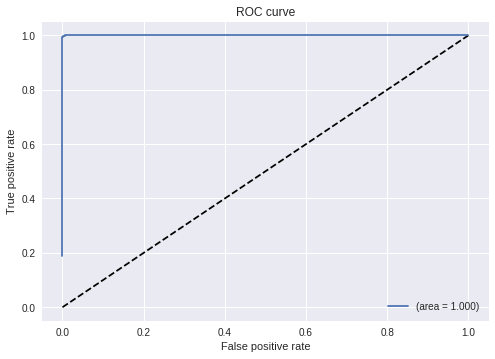

Best threshold (max tpr - fpr): 0.073416


In [29]:
plot_roc_curve_and_best_thrs(1 - train_generator.classes, y_test_preds_model11C_train.ravel())

In [30]:
results_to_vals = np.vectorize(lambda x: 'home' if x < 0.073416 else 'out')

predicted_report(results_to_vals(1 - train_generator.classes), results_to_vals(y_test_preds_model11C_train.flatten()))

# Notes: lower precision -> more false positives. lower recall -> more false negatives
# In our case, we're interested in the recall metric: we want to avoid cases where the system says Pépito is at home and he's actually outside
#(we want to avoid false negatives)
# In predicted_report, each metric on each row means that metric's been calculated using that label as the positive class

Predicted  home   out   All
Actual                     
home       3074     6  3080
out           4  3068  3072
All        3078  3074  6152

Accuracy: 0.998375

             precision    recall  f1-score   support

       home       1.00      1.00      1.00      3080
        out       1.00      1.00      1.00      3072

avg / total       1.00      1.00      1.00      6152



Dev set:

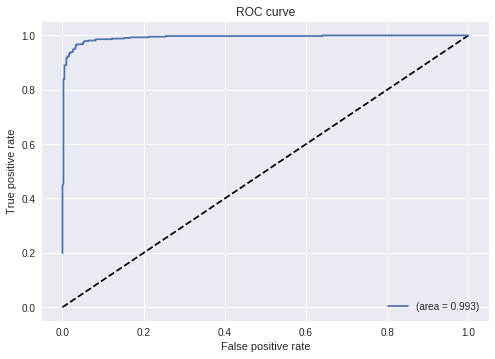

Best threshold (max tpr - fpr): 0.153082


In [46]:
plot_roc_curve_and_best_thrs(1 - dev_generator.classes, y_test_preds_model11C_dev.ravel())

In [53]:
results_to_vals = np.vectorize(lambda x: 'home' if x < 0.153082 else 'out')

predicted_report(results_to_vals(1 - dev_generator.classes), results_to_vals(y_test_preds_model11C_dev.flatten()))

# Notes: lower precision -> more false positives. lower recall -> more false negatives
# In our case, we're interested in the recall metric: we want to avoid cases where the system says Pépito is at home and he's actually outside
#(we want to avoid false negatives)
# In predicted_report, each metric on each row means that metric's been calculated using that label as the positive class

Predicted  home  out  All
Actual                   
home        413   15  428
out          14  413  427
All         427  428  855

Accuracy: 0.966082

             precision    recall  f1-score   support

       home       0.97      0.96      0.97       428
        out       0.96      0.97      0.97       427

avg / total       0.97      0.97      0.97       855



Test set:

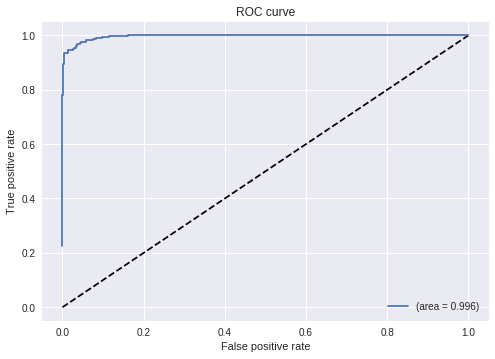

Best threshold (max tpr - fpr): 0.049466


In [96]:
plot_roc_curve_and_best_thrs(1 - test_generator.classes, y_test_preds_model11C.ravel())

In [47]:
predicted_report(results_to_vals(1 - test_generator.classes), results_to_vals(y_test_preds_model11C.flatten()))

# Notes: lower precision -> more false positives. lower recall -> more false negatives
# In our case, we're interested in the recall metric: we want to avoid cases where the system says Pépito is at home and he's actually outside
#(we want to avoid false negatives)
# In predicted_report, each metric on each row means that metric's been calculated using that label as the positive class

Predicted  home  out   All
Actual                    
home        416   12   428
out          27  549   576
All         443  561  1004

Accuracy: 0.961155

             precision    recall  f1-score   support

       home       0.94      0.97      0.96       428
        out       0.98      0.95      0.97       576

avg / total       0.96      0.96      0.96      1004



## Model 12

In [59]:
model12.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 480, 640)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 480, 640)       866       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 2, 480, 640)       8         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2, 480, 640)       0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 2, 240, 320)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 240, 320)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 4, 240, 320)       292       
__________

Train set:

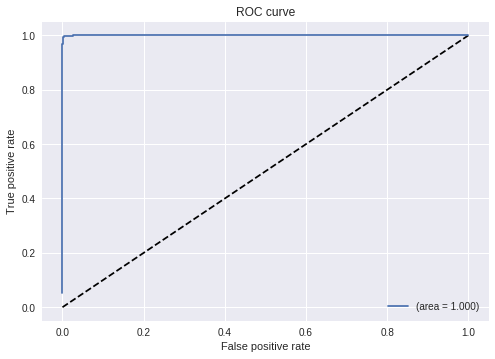

Best threshold (max tpr - fpr): 0.181927


In [31]:
plot_roc_curve_and_best_thrs(1 - train_generator.classes, y_test_preds_model12_train.ravel())

In [32]:
results_to_vals = np.vectorize(lambda x: 'home' if x < 0.181927 else 'out')

predicted_report(results_to_vals(1 - train_generator.classes), results_to_vals(y_test_preds_model12_train.flatten()))

# Notes: lower precision -> more false positives. lower recall -> more false negatives
# In our case, we're interested in the recall metric: we want to avoid cases where the system says Pépito is at home and he's actually outside
#(we want to avoid false negatives)
# In predicted_report, each metric on each row means that metric's been calculated using that label as the positive class

Predicted  home   out   All
Actual                     
home       3064    16  3080
out           9  3063  3072
All        3073  3079  6152

Accuracy: 0.995936

             precision    recall  f1-score   support

       home       1.00      0.99      1.00      3080
        out       0.99      1.00      1.00      3072

avg / total       1.00      1.00      1.00      6152



Dev set:

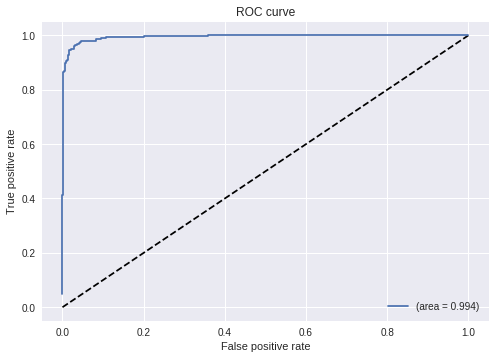

Best threshold (max tpr - fpr): 0.419209


In [48]:
plot_roc_curve_and_best_thrs(1 - dev_generator.classes, y_test_preds_model12_dev.ravel())

In [54]:
results_to_vals = np.vectorize(lambda x: 'home' if x < 0.419209 else 'out')

predicted_report(results_to_vals(1 - dev_generator.classes), results_to_vals(y_test_preds_model12_dev.flatten()))

# Notes: lower precision -> more false positives. lower recall -> more false negatives
# In our case, we're interested in the recall metric: we want to avoid cases where the system says Pépito is at home and he's actually outside
#(we want to avoid false negatives)
# In predicted_report, each metric on each row means that metric's been calculated using that label as the positive class

Predicted  home  out  All
Actual                   
home        415   13  428
out          16  411  427
All         431  424  855

Accuracy: 0.966082

             precision    recall  f1-score   support

       home       0.96      0.97      0.97       428
        out       0.97      0.96      0.97       427

avg / total       0.97      0.97      0.97       855



Test set:

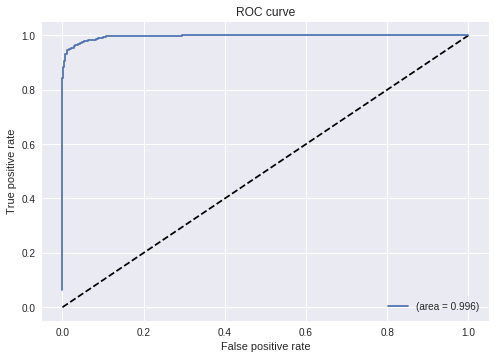

Best threshold (max tpr - fpr): 0.523093


In [98]:
plot_roc_curve_and_best_thrs(1 - test_generator.classes, y_test_preds_model12.ravel())

In [49]:
predicted_report(results_to_vals(1 - test_generator.classes), results_to_vals(y_test_preds_model12.flatten()))

# Notes: lower precision -> more false positives. lower recall -> more false negatives
# In our case, we're interested in the recall metric: we want to avoid cases where the system says Pépito is at home and he's actually outside
#(we want to avoid false negatives)
# In predicted_report, each metric on each row means that metric's been calculated using that label as the positive class

Predicted  home  out   All
Actual                    
home        416   12   428
out          23  553   576
All         439  565  1004

Accuracy: 0.965139

             precision    recall  f1-score   support

       home       0.95      0.97      0.96       428
        out       0.98      0.96      0.97       576

avg / total       0.97      0.97      0.97      1004



# Conclusions

Either Model12 or Model11C seem to be the best models, but Model12 shows a better recall metric so I think it should be the one to use.

Please note I've used the best threshold for the dev set as cutoff for the test set. I could have explored other criteria to choose the best threshold such us using the one that maximizes F1 or F2.

I'm aware that maybe the models asessed here (except Model11A and Model11B) might suffer overfitting (training set metrics close to 1) so maybe I should take a look into that.

## Exploring mistaken predictions

In [0]:
probs_to_binary = np.vectorize(lambda x: 0 if x < 0.419209 else 1)

error_indices = np.where( ((1 - test_generator.classes) -  probs_to_binary(y_test_preds_model12.flatten())) != 0)[0]

array(['home/PepitoTheCat-358705792687419394-20130720_235140-img1.jpg',
       'home/PepitoTheCat-359270201906315264-20130722_131425-img1.jpg',
       'home/PepitoTheCat-390188389338587136-20131015_205216-img1.jpg',
       'home/PepitoTheCat-396239051402911744-20131101_123526-img1.jpg',
       'home/PepitoTheCat-420058972469473281-20140106_060718-img1.jpg',
       'home/PepitoTheCat-427305575764856832-20140126_060242-img1.jpg',
       'home/PepitoTheCat-462730035057532928-20140504_010652-img1.jpg',
       'home/PepitoTheCat-479020158489350144-20140617_235800-img1.jpg',
       'home/PepitoTheCat-485271897098035200-20140705_060010-img1.jpg',
       'home/PepitoTheCat-506678399222288384-20140902_074158-img1.jpg',
       'home/PepitoTheCat-586143275104346112-20150409_142701-img1.jpg',
       'home/PepitoTheCat-587360476138344448-20150412_230344-img1.jpg',
       'home/PepitoTheCat-644500876363759616-20150917_151917-img1.jpg',
       'home/PepitoTheCat-651118317705367555-20151005_213438-img

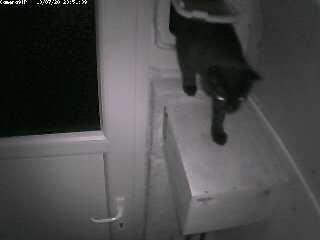

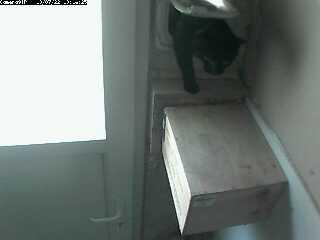

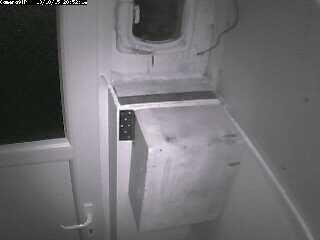

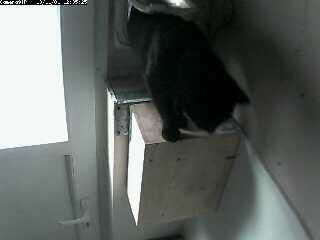

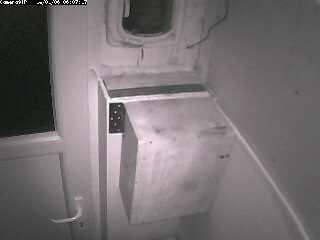

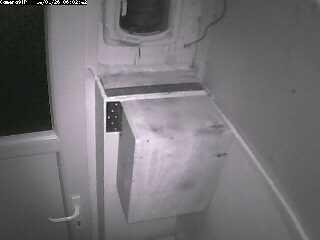

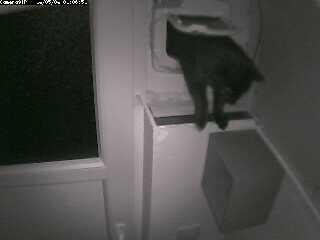

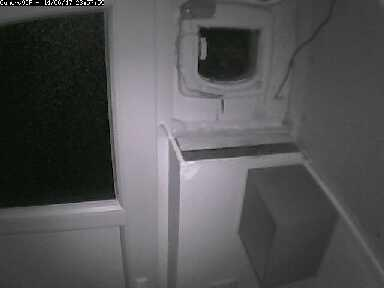

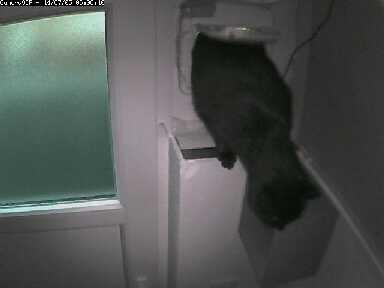

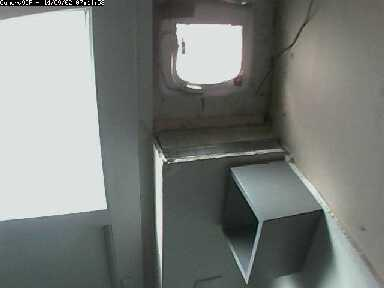

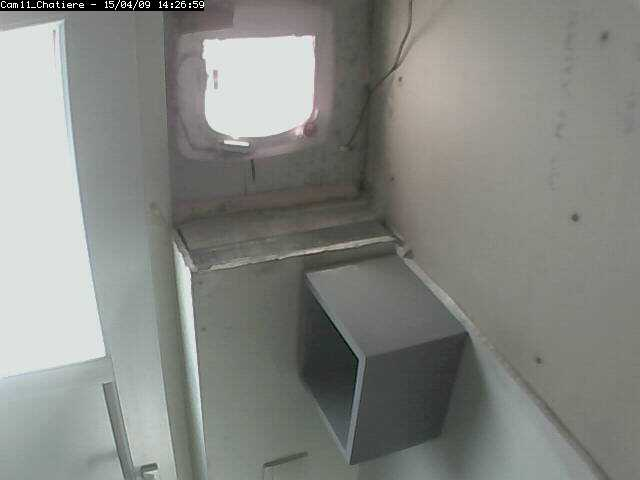

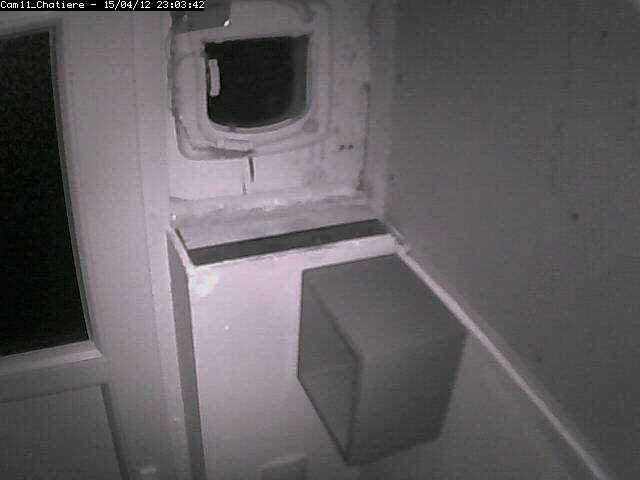

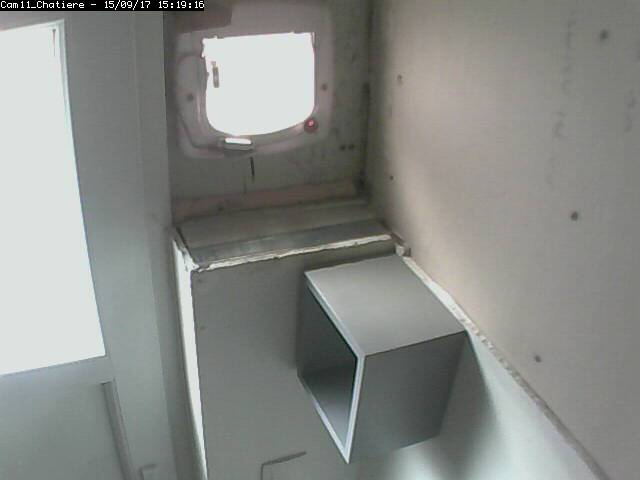

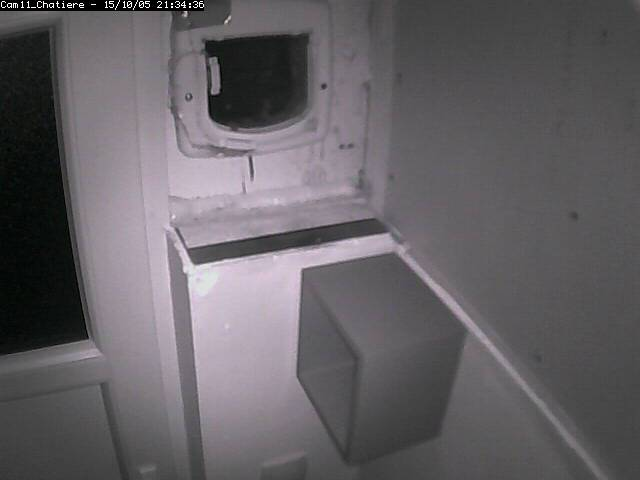

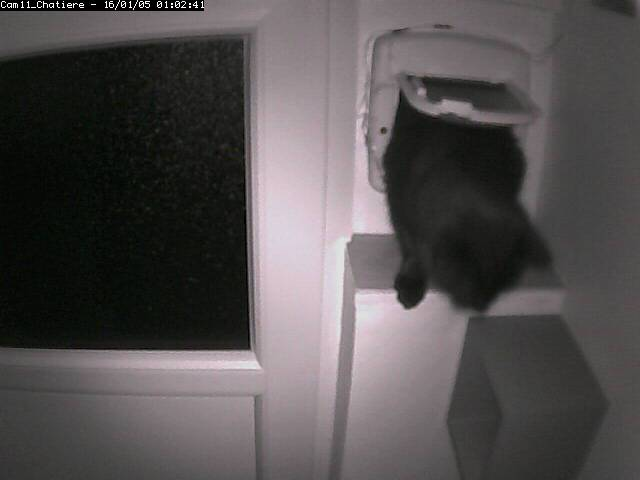

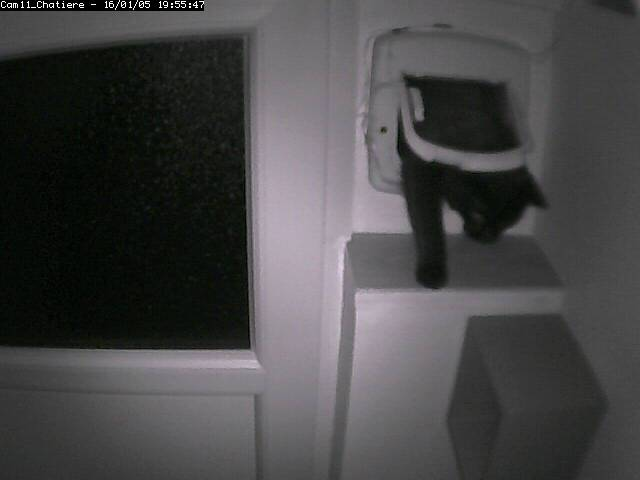

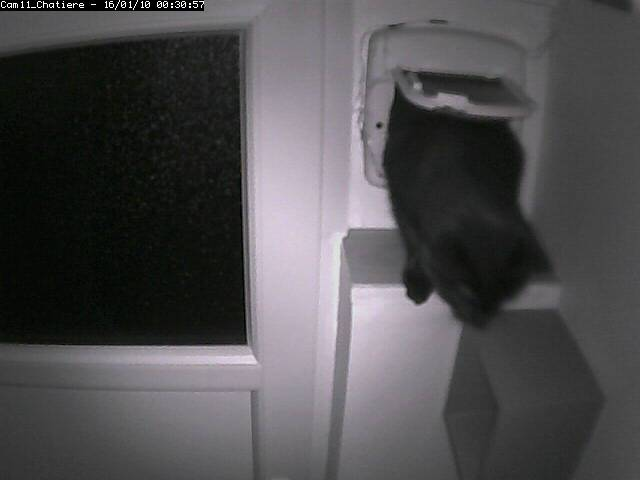

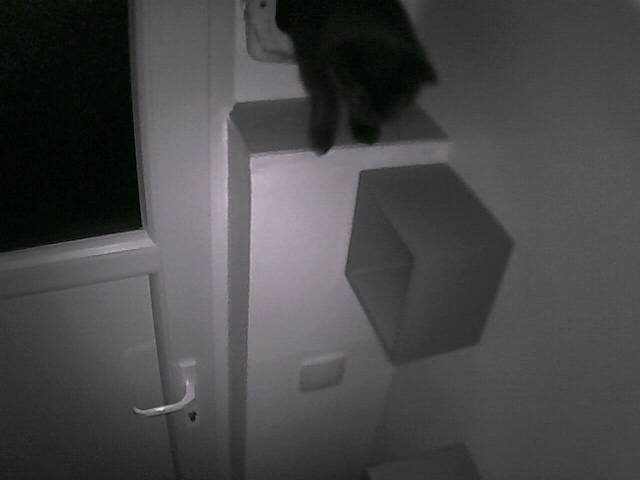

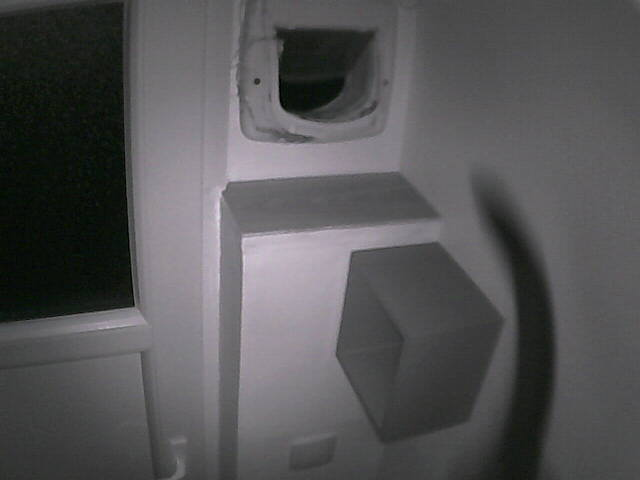

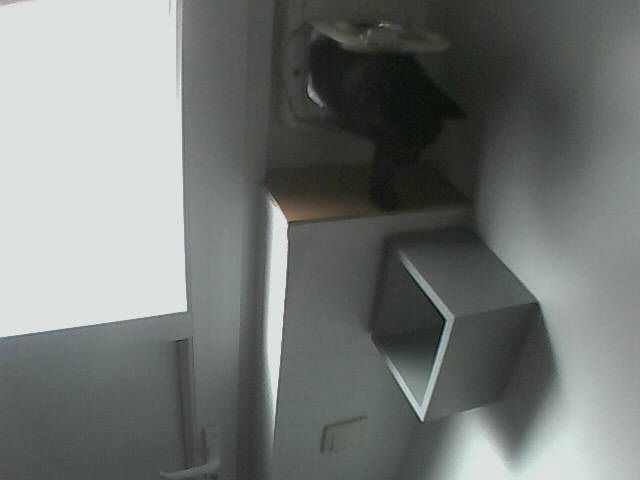

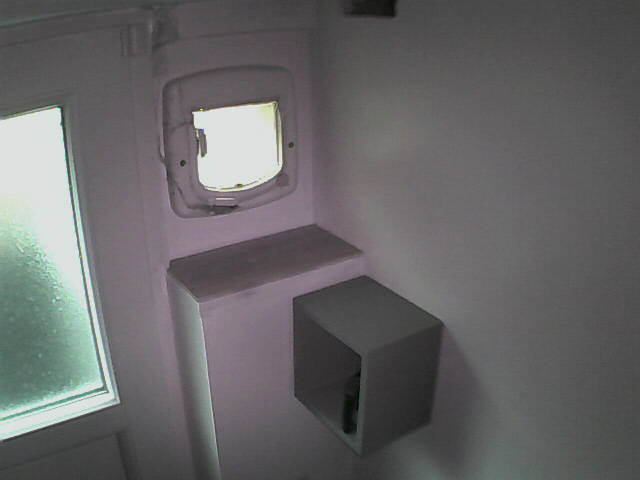

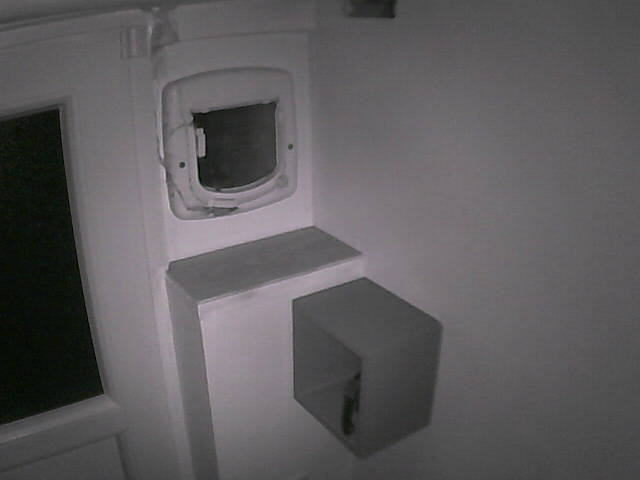

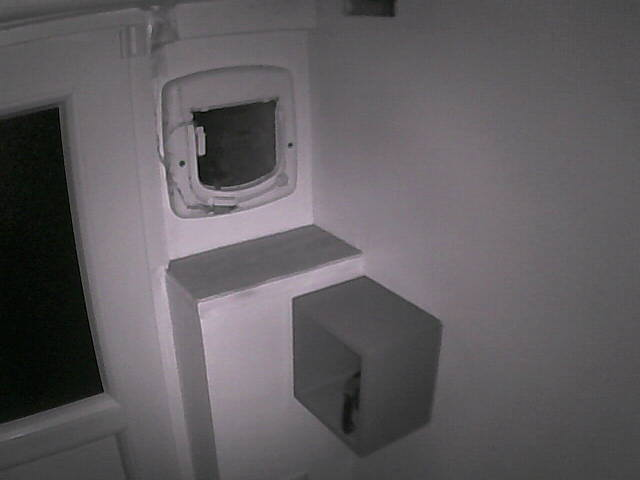

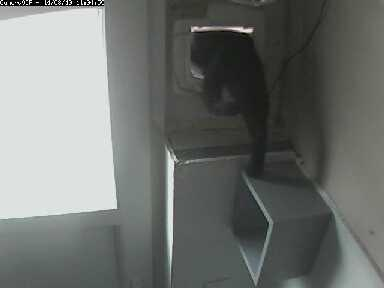

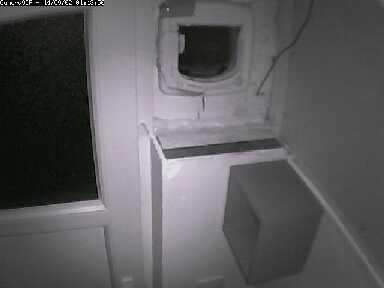

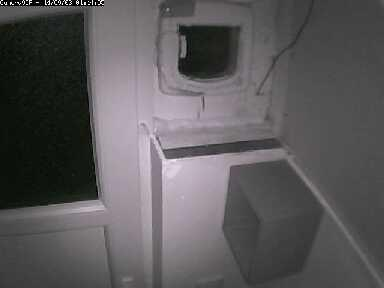

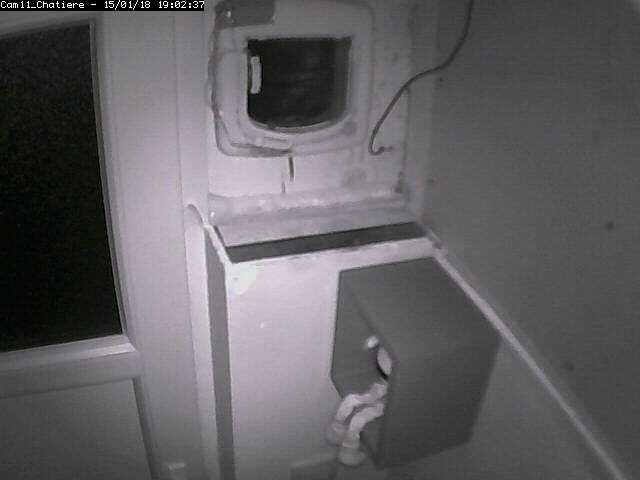

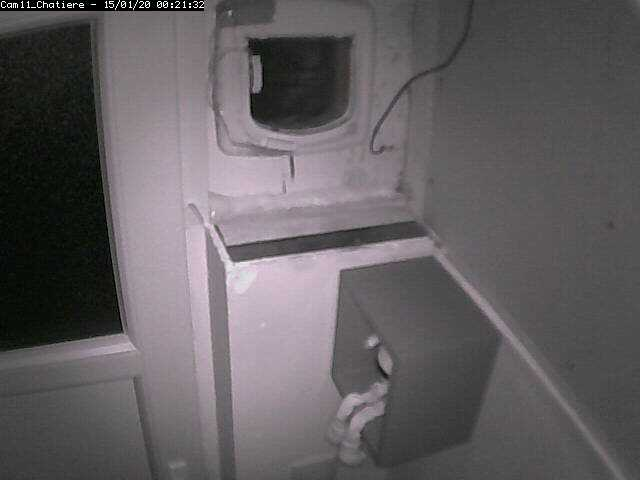

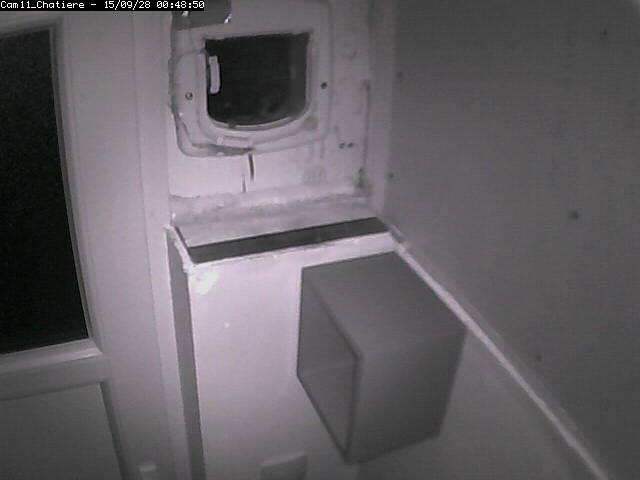

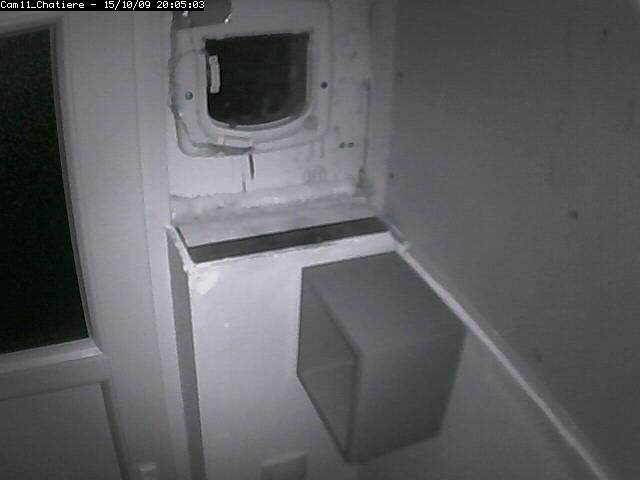

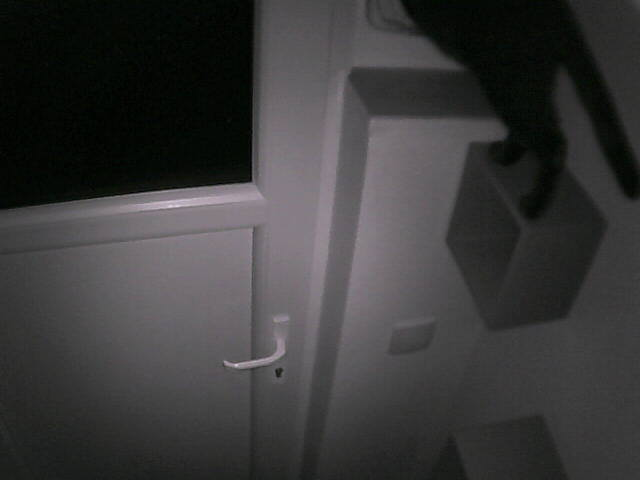

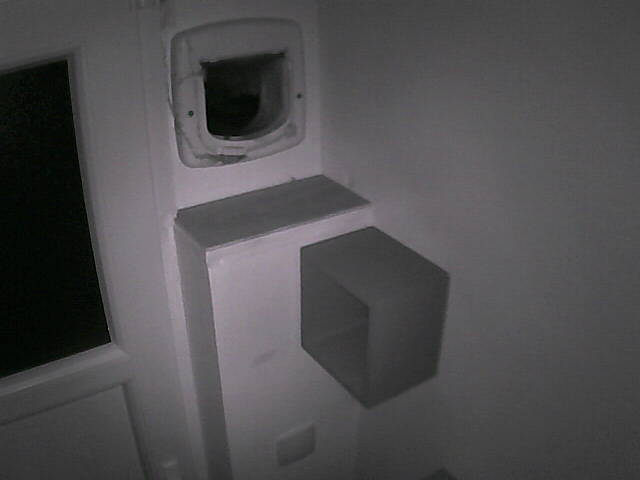

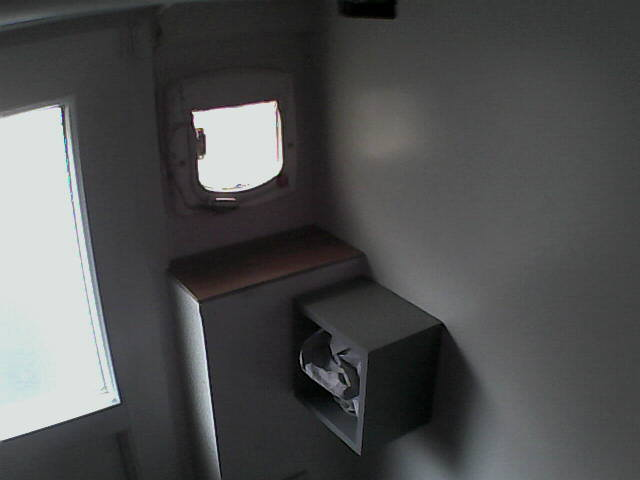

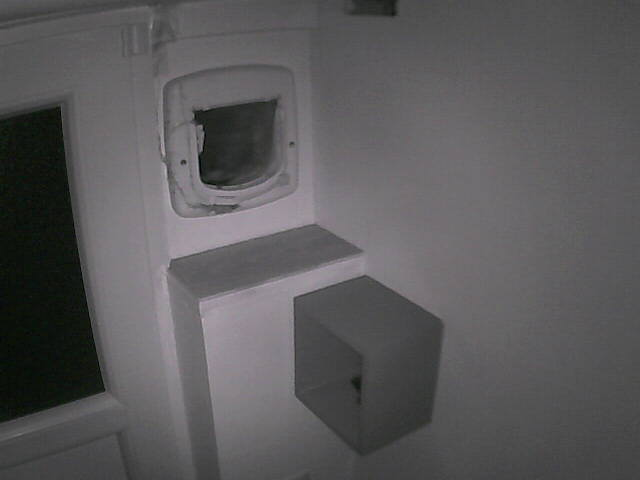

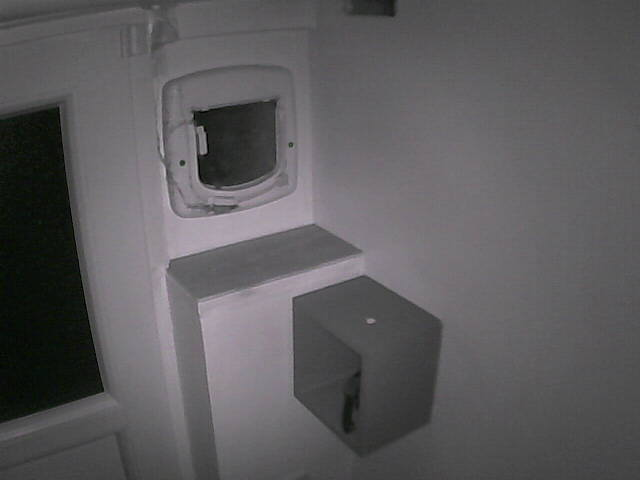

In [100]:
%matplotlib inline
from IPython.display import Image, display
from IPython.core.display import HTML 

for filename in np.array(test_generator.filenames)[error_indices]:
  display(Image(filename = 'test/' + filename, width=320, height=240))

Two ideas from the images the model couldn't get it right: 
- The angle of the camera may change
- In many cases the cat doesn't appear in the image (no way you can tell if the cat is getting in or out)